In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
fl = 'D:/Data/RandomWalkiSIM/Data/'
folder_fl = fl + 'Data_and_Figs/'
savedir = folder_fl


Shape_Metrics = pd.read_csv(folder_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)
#drop the cell that has the mistake in segmentation
Shape_Metrics = Shape_Metrics.drop(Shape_Metrics.Cell_Volume.idxmax())


#Add Elongation metric
Shape_Metrics['Cell_Elongation'] = Shape_Metrics['Cell_MajorAxis']/Shape_Metrics['Cell_MinorAxis']

#sphericity calculation (ratio of surface area of circle with same volume to actual surface area)
Cell_Sphere = []
for index, row in Shape_Metrics.iterrows():
    #cell sphericity
    r = ((3*row.Cell_Volume)/(4*math.pi)) ** (1/3)
    SA = 4*math.pi*r
    Cell_Sphere.append(SA/row.Cell_SurfaceArea)
Shape_Metrics['Cell_Sphericity'] = Cell_Sphere


######### Get angles of long axes relative to the axis of trajectory #############
RelativeAngles = pd.DataFrame()
UpDown = np.array([[1,1,0],
                  [1,-1,0],
                  [-1,-1,0],
                  [-1,1,0]])
LeftRight = np.array([[1,0,1],
                      [1,0,-1],
                      [-1,0,-1],
                      [-1,0,1]])
xz, d = plane_eq(LeftRight)
xy, d = plane_eq(UpDown)

# row = RandomRotations.iloc[0]
for index, row in Shape_Metrics.iterrows():
    vectors = [i for i in row.index if 'MajorAxis_Vec' in i]
    angles = {}
    for i in range(int(len(vectors)/3)):
        arr = row[vectors[3*i:3*i+3]].to_numpy()
        if arr[0] < 0:
            arr = arr*-1
        #get angle between the vector and the planes
        UpDownAngle = distance(arr[0], arr[1], arr[2], arr[0], arr[1], 0)
        LeftRightAngle = distance(arr[0], arr[1], arr[2], arr[0], 0, arr[2])
        TotalAngle = distance(arr[0], arr[1], arr[2], 1, 0, 0)
        #append angles
        rx = vectors[0].split('_')[0]
        angles[rx +'_UpDownAngle'] = UpDownAngle if UpDownAngle<=90 else UpDownAngle-180
        angles[rx +'_LeftRightAngle'] = LeftRightAngle if LeftRightAngle<=90 else LeftRightAngle-180
        angles[rx +'_TotalAngle'] = TotalAngle
    RelativeAngles = RelativeAngles.append(angles, ignore_index=True)
    
#add the angles to the dataframe and remove vectors
Shape_Metrics = Shape_Metrics[[i for i in list(Shape_Metrics.columns) if '_Vec' not in i]]
RelativeAngles.index = Shape_Metrics.index
Shape_Metrics = Shape_Metrics.merge(RelativeAngles, left_index = True, right_index = True)





TotalFrame = Shape_Metrics.copy()
for x in TotalFrame.columns.to_list():
    if 'PC' in x:
        TotalFrame = TotalFrame.rename(columns = {x:x.replace('Cell_','')})
        
######## OPEN CELL INFO FROM DURING SEGMENTATION #############



#change generic structure columns to specific structure columns
strcols = [s for s in TotalFrame.columns.to_list() if "Structure" in s]
dictlist = []
for r, row in TotalFrame.iterrows():
    names = [row.structure +'_'+ s for s in strcols]
    values = row[strcols].values
    res = {names[i]: values[i] for i in range(len(names))}
#     res = pd.DataFrame([row[strcols].values],columns=names,index=[row.name])
    dictlist.append(res)
TotalFrame = TotalFrame.drop(columns=strcols).merge(pd.DataFrame(dictlist,index=TotalFrame.index), 
                                                    left_index = True, right_index = True)

#add a column that identifies cells across all frames
TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.index.to_list()]


# # #split dataframe into nuclear and cell halves
# # Cell_Metrics = TotalFrame[[i for i in list(TotalFrame.columns) if 'Cell_' in i]]
# # # Cell_Metrics.index = Shape_Metrics.cell
# # Nucleus_Metrics = TotalFrame[[i for i in list(TotalFrame.columns) if 'Nucleus_' in i]]
# # # Nucleus_Metrics.index = Shape_Metrics.cell
# # #remove names from individual frames
# # Cell_Metrics.columns = [i.replace('Cell_', '') for i in Cell_Metrics.columns]
# # Nucleus_Metrics.columns = [i.replace('Nucleus_', '') for i in Nucleus_Metrics.columns]


print(len(TotalFrame))


#get changes in PCs between consecutive frames of a movie
nbins = 24

#first bin PCs
hist, PC1bins = np.histogram(TotalFrame.PC1, nbins)
hist, PC2bins = np.histogram(TotalFrame.PC2, nbins)
hist, PC3bins = np.histogram(TotalFrame.PC3, nbins)
TotalFrame['PC1deltabins'] = np.digitize(TotalFrame.PC1, PC1bins)
TotalFrame['PC2deltabins'] = np.digitize(TotalFrame.PC2, PC2bins)
TotalFrame['PC3deltabins'] = np.digitize(TotalFrame.PC3, PC3bins)

#get frames that have data in the next time point and get the delta of PC1 and PC2 bins
apdf = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame')
    diffs = cell.frame.diff(periods=-1)
    x=0
    for c, row in cell.iterrows():
        if diffs.loc[c] == -1:
            row['deltaPC1'] = cell.iloc[x+1].PC1deltabins - cell.iloc[x].PC1deltabins
            row['deltaPC2'] = cell.iloc[x+1].PC2deltabins - cell.iloc[x].PC2deltabins
            row['deltaPC3'] = cell.iloc[x+1].PC3deltabins - cell.iloc[x].PC3deltabins
            row['deltamag12'] = sqrt(row['deltaPC1']**2 + row['deltaPC2']**2)
            row['deltamag13'] = sqrt(row['deltaPC1']**2 + row['deltaPC3']**2)
            row['deltamag23'] = sqrt(row['deltaPC2']**2 + row['deltaPC3']**2)
            row['cell'] = row.name
            apdf.append(row.to_dict())
        x+=1
        
#make into a dataframe
deltaframe = pd.DataFrame(apdf)        
deltaframe.index = deltaframe.cell

#add to existing bigger dataframe
TotalFrame = TotalFrame.merge(deltaframe[['deltaPC1','deltaPC2', 'deltaPC3', 'deltamag12',
                                         'deltamag13', 'deltamag23']],
                              left_index = True, right_index = True, how = 'outer')

print(len(TotalFrame))


#also digitize into smaller bins

smallbins = 8

#first bin PC1 and PC2 
hist, PC1bins = np.histogram(TotalFrame.PC1, smallbins)
hist, PC2bins = np.histogram(TotalFrame.PC2, smallbins)
hist, PC3bins = np.histogram(TotalFrame.PC3, smallbins)
TotalFrame['small_PC1deltabins'] = np.digitize(TotalFrame.PC1, PC1bins)
TotalFrame['small_PC2deltabins'] = np.digitize(TotalFrame.PC2, PC2bins)
TotalFrame['small_PC3deltabins'] = np.digitize(TotalFrame.PC3, PC3bins)

#get frames that have data in the next time point and get the delta of PC1 and PC2 bins
apdf = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame')
    diffs = cell.frame.diff(periods=-1)
    x=0
    for c, row in cell.iterrows():
        if diffs.loc[c] == -1:
            row['small_deltaPC1'] = cell.iloc[x+1].small_PC1deltabins - cell.iloc[x].small_PC1deltabins
            row['small_deltaPC2'] = cell.iloc[x+1].small_PC2deltabins - cell.iloc[x].small_PC2deltabins
            row['small_deltaPC3'] = cell.iloc[x+1].small_PC3deltabins - cell.iloc[x].small_PC3deltabins
            #check if cell didn't move in the 2D PC space
            if (cell.iloc[x+1].small_PC1deltabins == cell.iloc[x].small_PC1deltabins
                and cell.iloc[x+1].small_PC2deltabins == cell.iloc[x].small_PC2deltabins):
                row['pstay'] = 1
                row['pexit'] = 0
            elif abs(row.small_deltaPC1)>0 or abs(row.small_deltaPC2)>0:
                row['pstay'] = 0
                row['pexit'] = 1 
                
            row['cell'] = row.name
            apdf.append(row.to_dict())
        x+=1
        
        
        
#make into a dataframe
deltaframe = pd.DataFrame(apdf)        
deltaframe.index = deltaframe.cell

#add to existing bigger dataframe
TotalFrame = TotalFrame.merge(deltaframe[['small_deltaPC1','small_deltaPC2',
                                          'small_deltaPC3', 'pstay', 'pexit']],
                              left_index = True, right_index = True, how = 'outer')
print(len(TotalFrame))



#get changes in PCs between consecutive frames of a movie for streamlines
minn = (TotalFrame.PC1deltabins-1).min()-(nbins/2)
maxx = (TotalFrame.PC1deltabins-1).max()-(nbins/2)
Y, X = np.mgrid[minn:maxx:1000j, minn:maxx:1000j]
#first bin PCs
hist, PC1bins = np.histogram(TotalFrame.PC1, X[0,:])
hist, PC2bins = np.histogram(TotalFrame.PC2, X[0,:])
hist, PC3bins = np.histogram(TotalFrame.PC3, X[0,:])
TotalFrame['PC1streamdeltabins'] = np.digitize(TotalFrame.PC1, PC1bins)
TotalFrame['PC2streamdeltabins'] = np.digitize(TotalFrame.PC2, PC2bins)
TotalFrame['PC3streamdeltabins'] = np.digitize(TotalFrame.PC3, PC3bins)

#get frames that have data in the next time point and get the delta of PC1 and PC2 bins
apdf = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame')
    diffs = cell.frame.diff(periods=-1)
    x=0
    for c, row in cell.iterrows():
        if diffs.loc[c] == -1:
            row['streamdeltaPC1'] = cell.iloc[x+1].PC1streamdeltabins - cell.iloc[x].PC1streamdeltabins
            row['streamdeltaPC2'] = cell.iloc[x+1].PC2streamdeltabins - cell.iloc[x].PC2streamdeltabins
            row['streamdeltaPC3'] = cell.iloc[x+1].PC3streamdeltabins - cell.iloc[x].PC3streamdeltabins
            row['cell'] = row.name
            apdf.append(row.to_dict())
        x+=1
        
#make into a dataframe
deltaframe = pd.DataFrame(apdf)        
deltaframe.index = deltaframe.cell

#add to existing bigger dataframe
TotalFrame = TotalFrame.merge(deltaframe[['streamdeltaPC1','streamdeltaPC2', 'streamdeltaPC3']],
                              left_index = True, right_index = True, how = 'outer')

print(len(TotalFrame))




################# Generate z-scored PCs ##############
from scipy.stats import zscore
from sklearn.decomposition import PCA

npcs = 2

shcoeffs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'shcoeffs' in x]].reset_index(drop=True)
zshcoeffs = shcoeffs.apply(zscore)
zshcoeffs.fillna(0,inplace=True)

# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(zshcoeffs)
matrix_of_features_transform = pca.transform(zshcoeffs)

# Dataframe of transformed variable
pc_names = [f"zPC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = TotalFrame.index)

TotalFrame = TotalFrame.merge(df_trans, left_index = True, right_index = True)

# Adjust the sign of PCs so that larger cells are represent by positive values
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(TotalFrame.Cell_Volume.values, TotalFrame[pc_name].values)
    if pearson[0, 1] < 0:
        TotalFrame[pc_name] *= -1
        pca.components_[pcid] *= -1



#get changes in PCs between consecutive frames of a movie
znbins = 60

#first bin PCs
hist, PC1bins = np.histogram(TotalFrame.zPC1, znbins)
hist, PC2bins = np.histogram(TotalFrame.zPC2, znbins)
TotalFrame['zPC1deltabins'] = np.digitize(TotalFrame.zPC1, PC1bins)
TotalFrame['zPC2deltabins'] = np.digitize(TotalFrame.zPC2, PC2bins)

#get frames that have data in the next time point and get the delta of PC1 and PC2 bins
apdf = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame')
    diffs = cell.frame.diff(periods=-1)
    x=0
    for c, row in cell.iterrows():
        if diffs.loc[c] == -1:
            row['zdeltaPC1'] = cell.iloc[x+1].zPC1deltabins - cell.iloc[x].zPC1deltabins
            row['zdeltaPC2'] = cell.iloc[x+1].zPC2deltabins - cell.iloc[x].zPC2deltabins
            row['zdeltamag12'] = sqrt(row['zdeltaPC1']**2 + row['zdeltaPC2']**2)
            row['cell'] = row.name
            apdf.append(row.to_dict())
        x+=1
        
#make into a dataframe
deltaframe = pd.DataFrame(apdf)        
deltaframe.index = deltaframe.cell

#add to existing bigger dataframe
TotalFrame = TotalFrame.merge(deltaframe[['zdeltaPC1','zdeltaPC2', 'zdeltamag12']],
                              left_index = True, right_index = True, how = 'outer')



#also digitize into smaller bins

zsmallbins = 10

#first bin PC1 and PC2 
hist, PC1bins = np.histogram(TotalFrame.zPC1, zsmallbins)
hist, PC2bins = np.histogram(TotalFrame.zPC2, zsmallbins)
TotalFrame['zsmall_PC1deltabins'] = np.digitize(TotalFrame.zPC1, PC1bins)
TotalFrame['zsmall_PC2deltabins'] = np.digitize(TotalFrame.zPC2, PC2bins)


#get frames that have data in the next time point and get the delta of PC1 and PC2 bins
apdf = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame')
    diffs = cell.frame.diff(periods=-1)
    x=0
    for c, row in cell.iterrows():
        if diffs.loc[c] == -1:
            row['zsmall_deltaPC1'] = cell.iloc[x+1].zsmall_PC1deltabins - cell.iloc[x].zsmall_PC1deltabins
            row['zsmall_deltaPC2'] = cell.iloc[x+1].zsmall_PC2deltabins - cell.iloc[x].zsmall_PC2deltabins
            #check if cell didn't move in the 2D PC space
            if (cell.iloc[x+1].zsmall_PC1deltabins == cell.iloc[x].zsmall_PC1deltabins
                and cell.iloc[x+1].zsmall_PC2deltabins == cell.iloc[x].zsmall_PC2deltabins):
                row['zpstay'] = 1
                row['zpexit'] = 0
            elif abs(row.zsmall_deltaPC1)>0 or abs(row.zsmall_deltaPC2)>0:
                row['zpstay'] = 0
                row['zpexit'] = 1 
                
            row['cell'] = row.name
            apdf.append(row.to_dict())
        x+=1
        
        
        
#make into a dataframe
deltaframe = pd.DataFrame(apdf)        
deltaframe.index = deltaframe.cell

#add to existing bigger dataframe
TotalFrame = TotalFrame.merge(deltaframe[['zsmall_deltaPC1','zsmall_deltaPC2', 'zpstay', 'zpexit']],
                              left_index = True, right_index = True, how = 'outer')


892
892
892
892


(array([  5.,  29., 140., 355., 224.,  79.,  46.,  11.,   2.,   1.]),
 array([-5.79434695, -4.31674601, -2.83914507, -1.36154413,  0.1160568 ,
         1.59365774,  3.07125868,  4.54885961,  6.02646055,  7.50406149,
         8.98166242]),
 <a list of 10 Patch objects>)

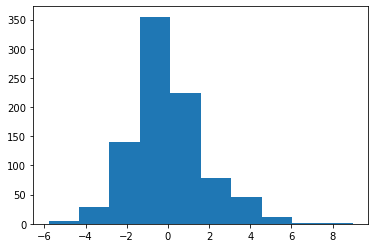

In [111]:
# TotalFrame[TotalFrame['zsmall_PC1deltabins']==11].zPC1, TotalFrame[TotalFrame['zsmall_PC1deltabins']==11].PC1
# TotalFrame.zPC1.sort_values(), TotalFrame.PC1.sort_values()
# type(TotalFrame['zsmall_PC1deltabins'][2])
# PC1bins
# TotalFrame.PC1.sort_values()
plt.hist(TotalFrame.zPC1)

In [301]:
########################## trying to make a streamline plot ##################

# hist, PC1bins = np.histogram(TotalFrame.PC1, X[0,:])
# hist
# np.digitize(TotalFrame.PC1, PC1bins)

minn = (TotalFrame.PC1deltabins-1).min()-(nbins/2)
maxx = (TotalFrame.PC1deltabins-1).max()-(nbins/2)
Y, X = np.mgrid[minn:maxx:1000j, minn:maxx:1000j]

#make numpy array with heatmap data
dX = np.zeros((X.shape))
dY = np.zeros((Y.shape))
for x in range(X.shape[-1]):
    for y in range(X.shape[0]):
        current = TotalFrame[(TotalFrame['PC1streamdeltabins'] == x+1) & (TotalFrame['PC2streamdeltabins'] == y+1)]
        if current.empty:
            pass
        elif current.streamdeltaPC1.dropna().empty:
            pass
        else:
            dX[y,x] = current.streamdeltaPC1.dropna().mean()
            dY[y,x] = current.streamdeltaPC2.dropna().mean()

            
            
import cartopy.crs as ccrs



####### https://github.com/SciTools/cartopy/issues/1388
# dX.max()*
nbins/1000

fig, ax = plt.subplots(1,1)#,figsize =(24, 20))


# ax.streamplot(X[0,:], Y[:,0], dX*(nbins/1000), dY*(nbins/1000),linewidth=5,density =3)
 
ax.streamplot(X[0,:], Y[:,0], dX*(nbins/1000), dY*(nbins/1000),
               transform=ccrs.PlateCarree(
                       central_longitude=0),
               density = 3)
# show plot
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'cartopy'

In [28]:


minn = (TotalFrame.PC1deltabins-1).min()-(nbins/2)
maxx = (TotalFrame.PC1deltabins-1).max()-(nbins/2)

w = 3
Y, X = np.mgrid[minn:maxx:1000j, minn:maxx:1000j]
U = -1 - X**2 + Y
X[0,:]
# Y, X, len(X)
# np.arange(minn, maxx,(maxx-minn)/1000)
# for i, cell in TotalFrame.groupby('CellID'):
#     print(i)
# interpolate.interp1d()

array([-12.        , -11.97597598, -11.95195195, -11.92792793,
       -11.9039039 , -11.87987988, -11.85585586, -11.83183183,
       -11.80780781, -11.78378378, -11.75975976, -11.73573574,
       -11.71171171, -11.68768769, -11.66366366, -11.63963964,
       -11.61561562, -11.59159159, -11.56756757, -11.54354354,
       -11.51951952, -11.4954955 , -11.47147147, -11.44744745,
       -11.42342342, -11.3993994 , -11.37537538, -11.35135135,
       -11.32732733, -11.3033033 , -11.27927928, -11.25525526,
       -11.23123123, -11.20720721, -11.18318318, -11.15915916,
       -11.13513514, -11.11111111, -11.08708709, -11.06306306,
       -11.03903904, -11.01501502, -10.99099099, -10.96696697,
       -10.94294294, -10.91891892, -10.89489489, -10.87087087,
       -10.84684685, -10.82282282, -10.7987988 , -10.77477477,
       -10.75075075, -10.72672673, -10.7027027 , -10.67867868,
       -10.65465465, -10.63063063, -10.60660661, -10.58258258,
       -10.55855856, -10.53453453, -10.51051051, -10.48

In [12]:
genes = ['CORO1A','FMNL1','sgControl']
for g in genes:
    num = TotalFrame[TotalFrame.Gene == g]
    print(f'There are {len(num)} images of genotype {g}')
    cellist = [x.split('frame')[0] for x in num.index]
    print(f'There are {len(pd.Series(cellist).unique())} cells of genotype {g}')


There are 358 images of genotype CORO1A
There are 27 cells of genotype CORO1A
There are 252 images of genotype FMNL1
There are 19 cells of genotype FMNL1
There are 310 images of genotype sgControl
There are 28 cells of genotype sgControl


In [303]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


In [7]:
from operator import itemgetter

frame = [int(re.search('(?<=frame_)\d*', x)[0]) for x in list(TotalFrame.cell)]
cell = [re.findall('.*cell_\d*',x)[0] for x in list(TotalFrame.cell)]
newframe = TotalFrame.copy()
newframe['frame'] = frame
newframe['cell'] = cell

getConsecutiveframes

consecutive =  pd.DataFrame([])
grouped = newframe.groupby('cell')
for i, cells in grouped:
    cells = cells.sort_values('frame').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    whichframes = np.array(max(runs, key=len), dtype=int)
    pullrows = [int(cells[cells['frame']==i].index[0]) for i in whichframes]
    consecutive = consecutive.append(cells.iloc[pullrows,:], ignore_index=True)
    

AttributeError: 'DataFrame' object has no attribute 'cell'

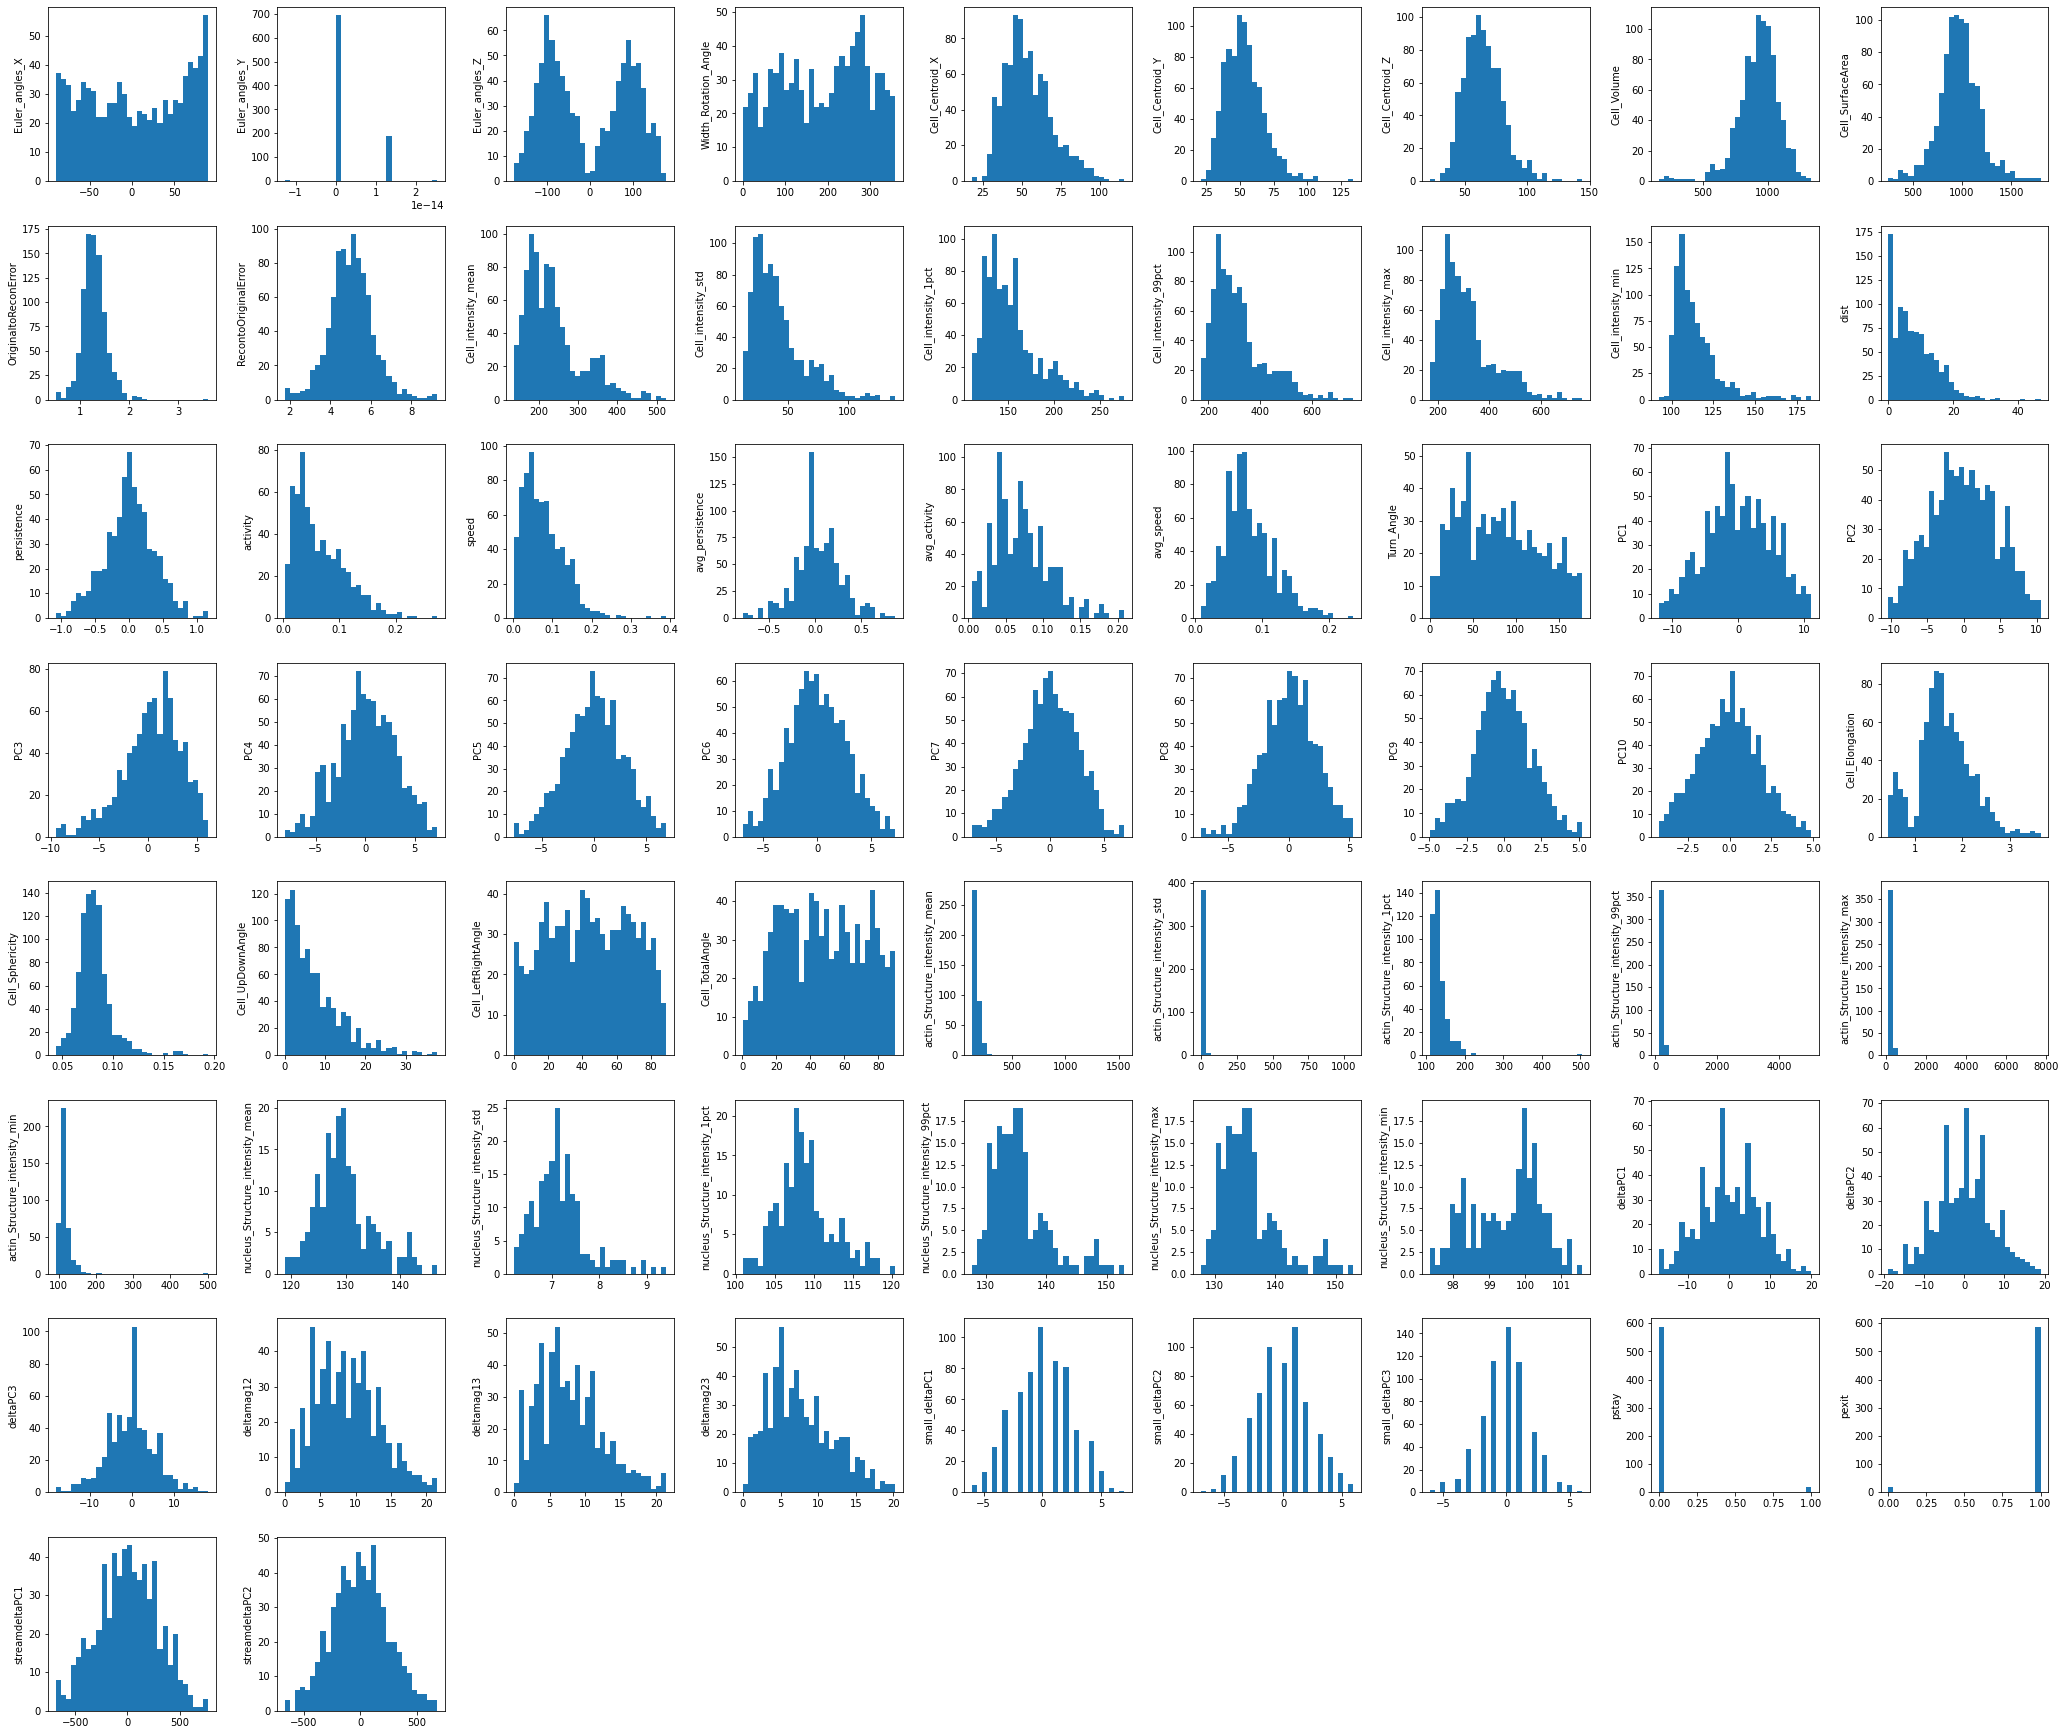

In [304]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell.1','CellID','structure','frame'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

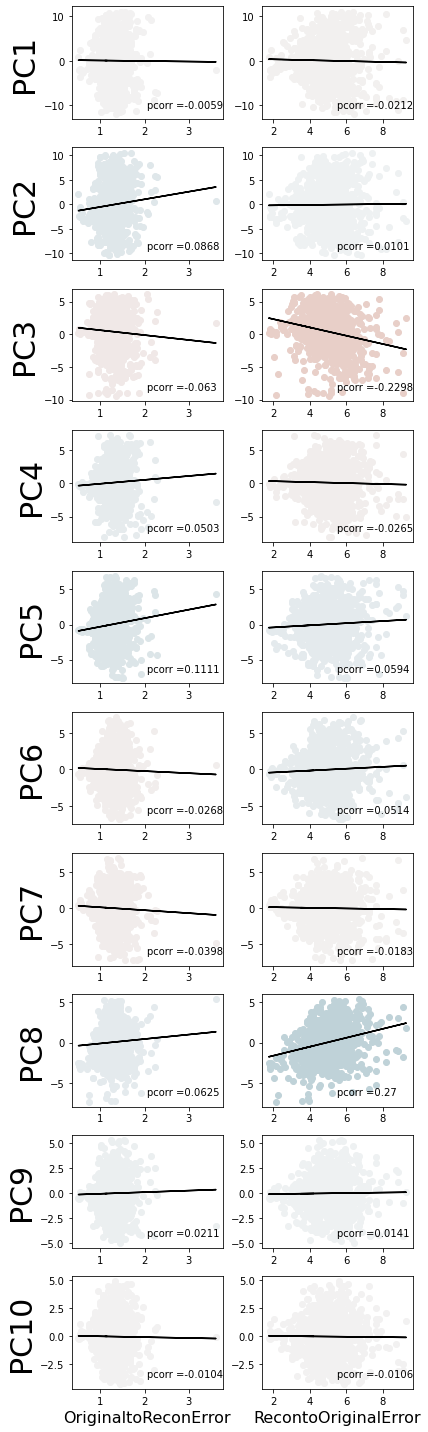

In [307]:

color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
metric_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'Error' in x]]
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(6,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = metric_frame.iloc[:,i]
        y = PC_frame[f'PC{q+1}']
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, intercept+slope*x, 'k')
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        ax.text(0.5, 0.1, 'pcorr ='+str(round(p_corr,4)),transform=ax.transAxes)




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 30) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 16) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

In [5]:
# get list of metrics that are significant by anova
GeneFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'Angle' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in GeneFrame.columns.to_list() if 'Gene' in x])

for c in GeneFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in GeneFrame.groupby('Gene')[c]]
    f_val, p_val = ss.f_oneway(*samples)
    print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(GeneFrame[c], GeneFrame['Gene']))
siglist
units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
        '(a.u.)','(a.u.)']

Name: Cell_Volume, F value: 12.965996515056306, p value: 2.828804456437016e-06
Name: Cell_SurfaceArea, F value: 2.085385579902482, p value: 0.12488276043056015
Name: Nucleus_Volume, F value: 10.068594154159566, p value: 4.7569689835828364e-05
Name: Nucleus_SurfaceArea, F value: 9.676354421691235, p value: 6.980403206963195e-05
Name: PC1, F value: 0.845990742763201, p value: 0.42948632653174346
Name: PC2, F value: 1.3481454179569827, p value: 0.2602660143714546
Name: PC3, F value: 22.443350529116028, p value: 3.1418015307745644e-10
Name: PC4, F value: 0.06822020636167148, p value: 0.934059785345352
Name: PC5, F value: 1.3181630158717372, p value: 0.268162895113419
Name: PC6, F value: 0.45819014706956923, p value: 0.6325804359047219
Name: PC7, F value: 4.965571792448094, p value: 0.007173831134213214
Name: PC8, F value: 2.017337058271598, p value: 0.13363377538115354
Name: PC9, F value: 0.8150555997825033, p value: 0.44295395519580383
Name: PC10, F value: 1.9849550436301464, p value: 0.1

In [6]:
siglist

['Cell_Elongation',
 'Cell_Sphericity',
 'Cell_Volume',
 'Nucleus_Elongation',
 'Nucleus_Sphericity',
 'Nucleus_SurfaceArea',
 'Nucleus_Volume',
 'PC3',
 'PC7']

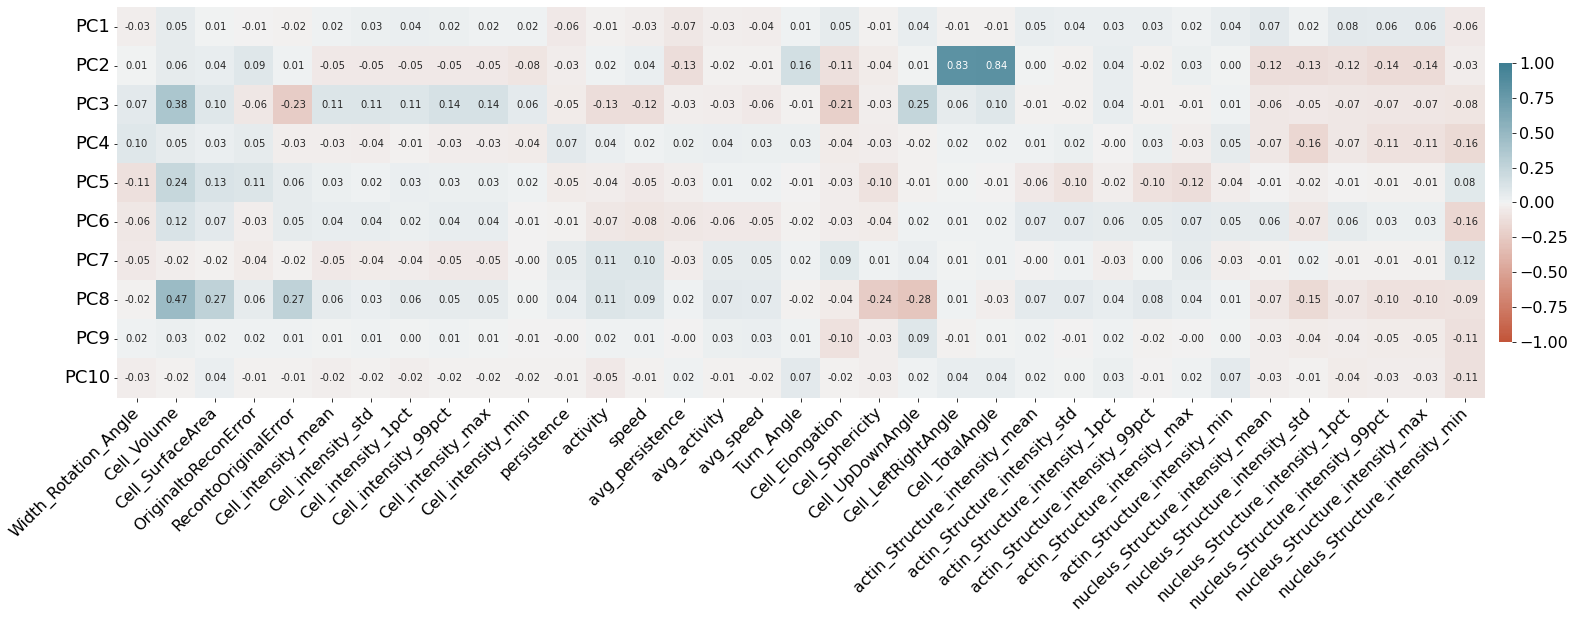

In [709]:
#correlations of shapes with PCs (PCs as rows)

coldrop = []
coldrop.extend([x for x in totalcorr.columns.to_list() if 'delta' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['pstay','pexit','frame','dist'])

PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'delta' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(folder_fl + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

In [19]:
len(PCsAndMetrics.columns)

48

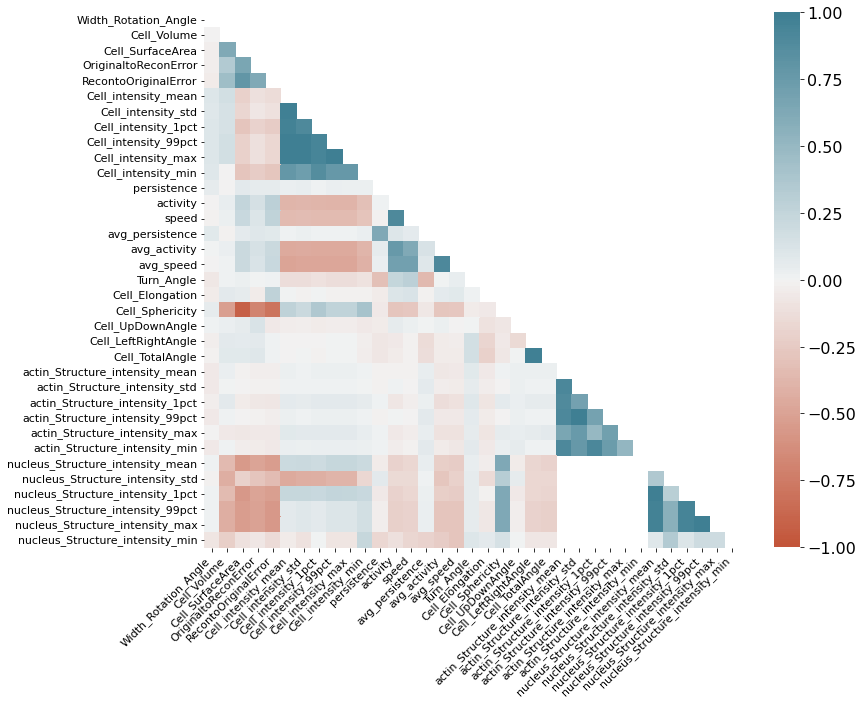

In [710]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['pexit','pstay','zpstay','zpexit','frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

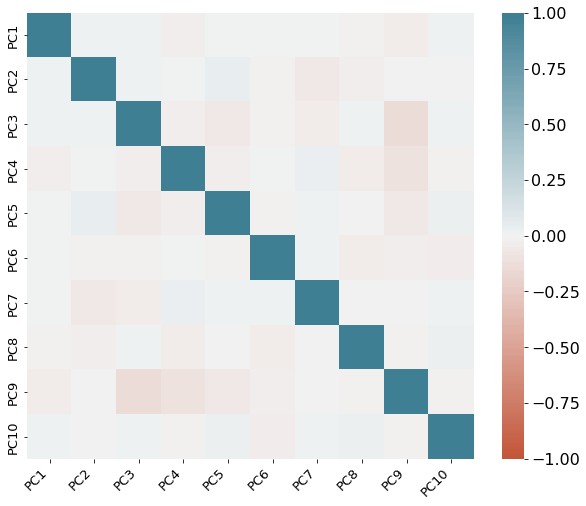

In [8]:
########################## PC Correlations #################

PCcorr = totalcorr.loc[[x for x in list(totalcorr.columns) if 'PC' in x]].loc[:,[x for x in list(totalcorr.columns) if 'PC' in x]]



#comparison of CELL features
fig, ax = plt.subplots(figsize=(len(PCcorr),len(PCcorr)))
ax = sns.heatmap(
    PCcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 13
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 13
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

# plt.savefig(folder_fl + 'Cell+Nuc Shape Metric corr rotationally aligned.png', bbox_inches='tight')

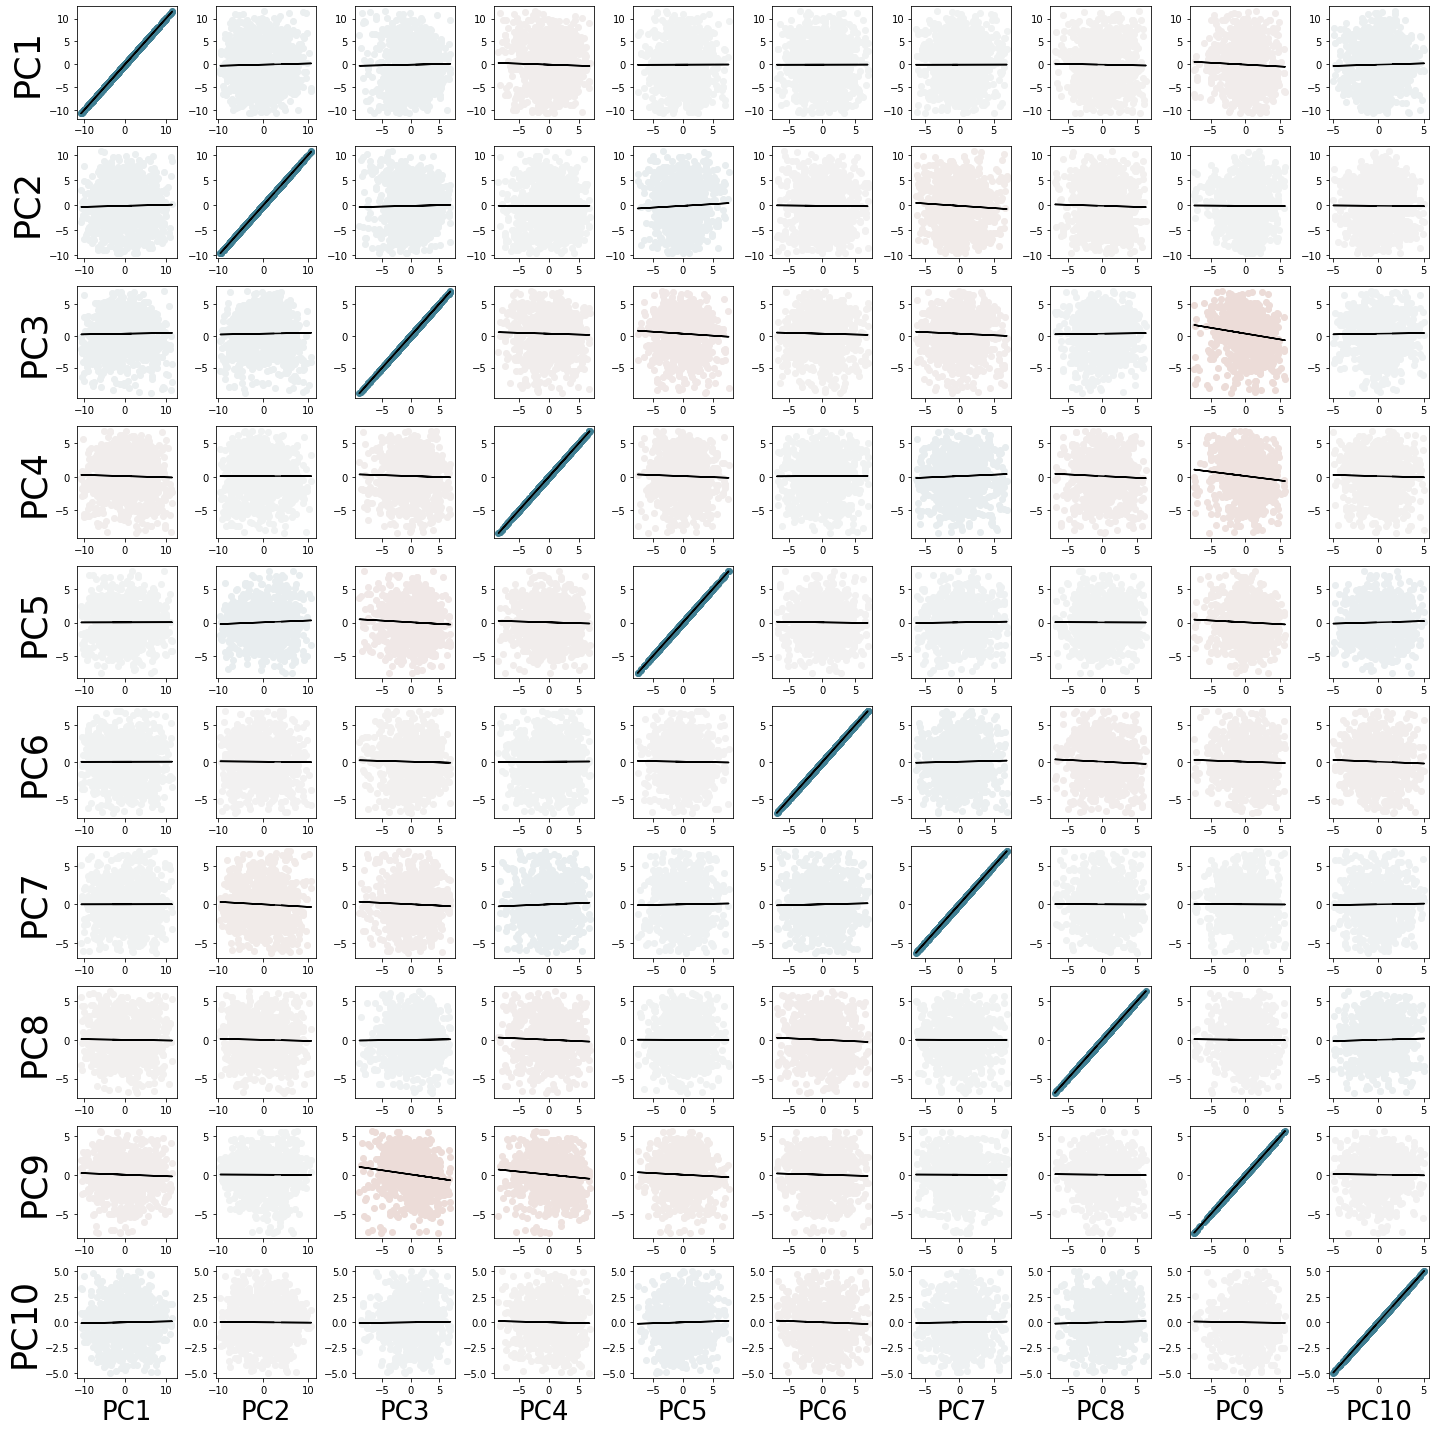

In [15]:
##################### look at scatter correlations between all PCs ###################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(PC_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = PC_frame[f'PC{i+1}']
        y = PC_frame[f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', f'PC{i+1}']
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = PC_frame.columns
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 26) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


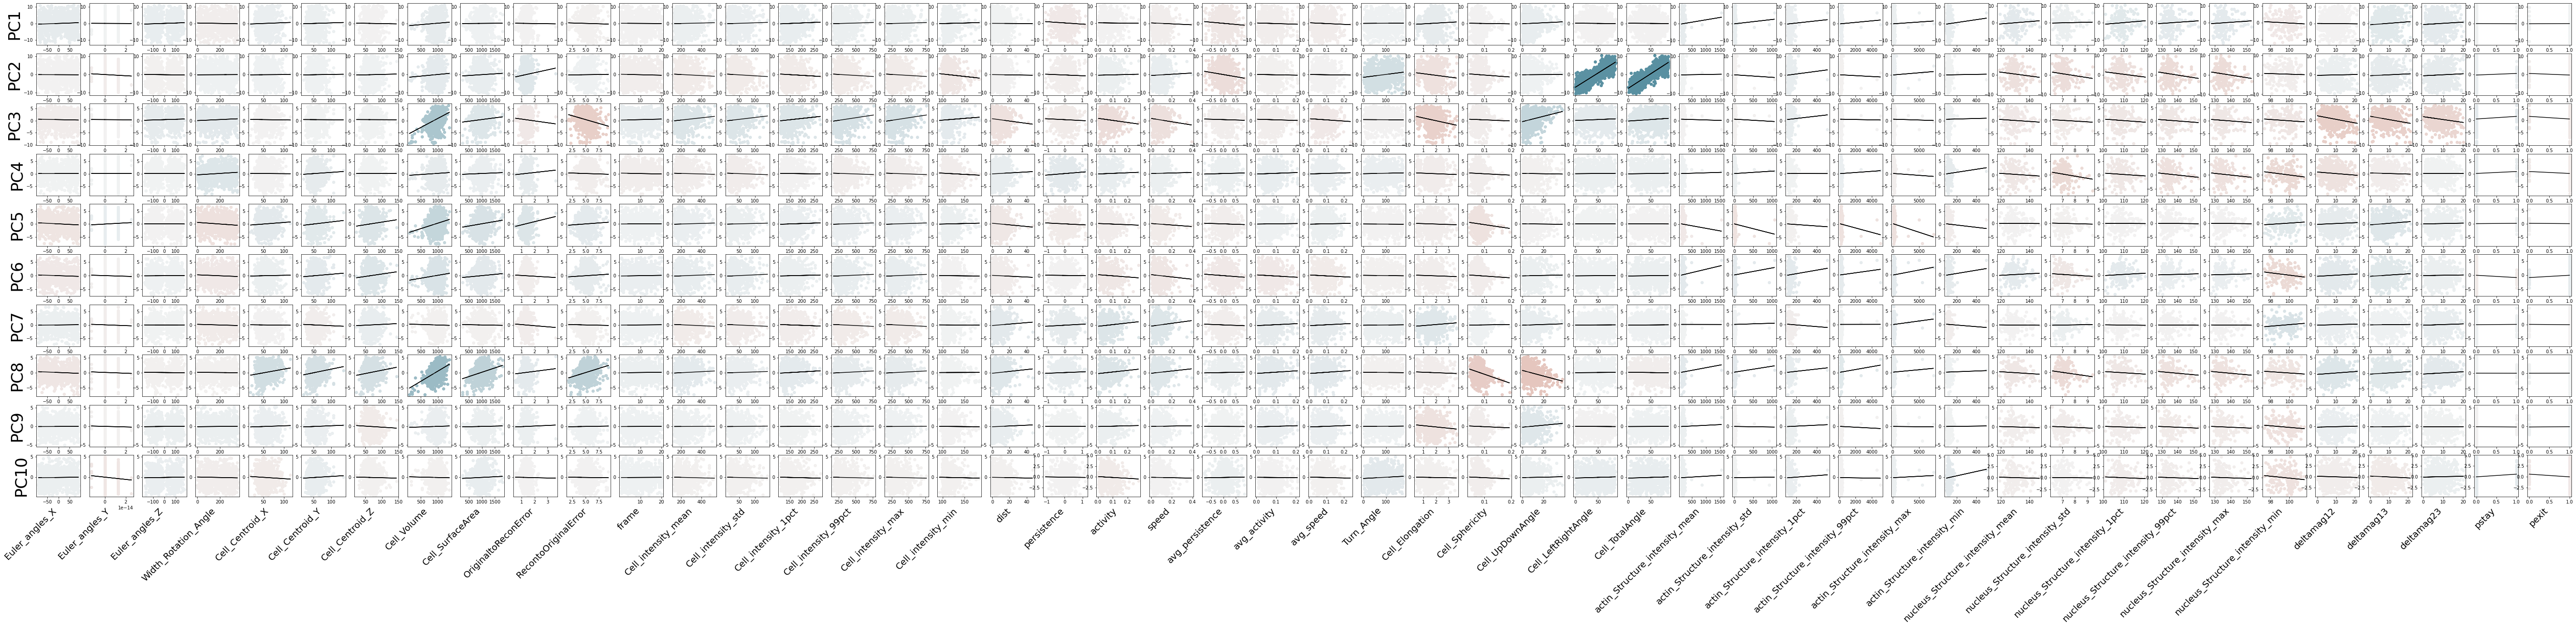

In [366]:
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(100,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i], rotation=45, horizontalalignment='right', fontsize = 20) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

In [359]:
# coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'delta' in i])
# coldrop, list(set(coldrop).intersection(to_remove))
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
# metric_frame.columns.to_list()
str(np.around(p_corr, decimals=2))

'-0.0'

In [39]:
# metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False]
dropcols = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()

Index(['20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_20_frame_11',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_16',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_11_frame_3',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_18',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_20_frame_10',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_17',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_13_frame_3',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_20',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_19',
       '20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_20_frame_12',
       ...
       '20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_3',
       '20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_4',
       '20221121_40

In [56]:
sns.color_palette("deep", as_cmap=True)[:3]

['#4C72B0', '#DD8452', '#55A868']

In [147]:
color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0]

0.9466666666666668

In [151]:
# color_scale = pd.DataFrame({'color':list(np.arange(0.2,1,0.8/180)[::-1]),
#               'value':list(np.arange(0,180,1))})
anglecolor

39.59620863975029

In [165]:
tuple([color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0]]*3)

(0.8177777777777779, 0.8177777777777779, 0.8177777777777779)

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 <a list of 7 Text major ticklabel objects>)

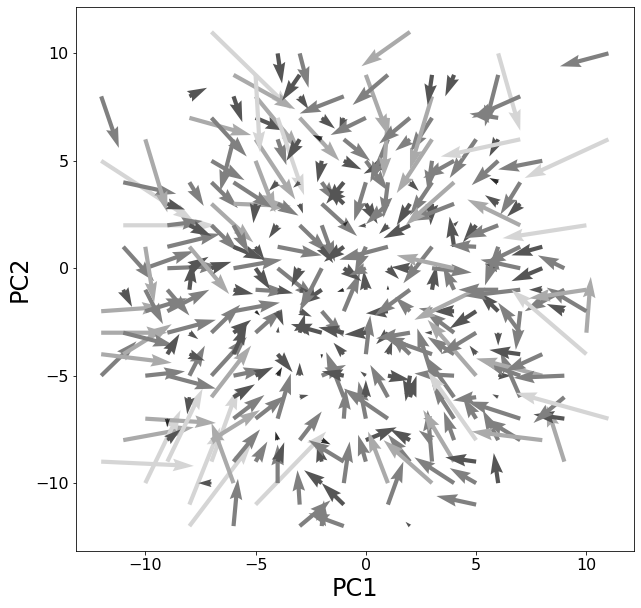

In [253]:
########### transition vectors in PC1 and PC2 space shaded by magnitude ###############
color_scale = pd.DataFrame({'color':list(sns.color_palette("gray", n_colors=5)),
              'value':list(np.arange(0,np.nanmax(np.array(maxmag)),np.nanmax(np.array(maxmag))/5))})

plt.figure(figsize=(10,10))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = current.deltamag12.mean()
#             print(anglecolor)
            plt.quiver(x-(nbins/2), y-(nbins/2), 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0])
            
plt.xlabel('PC1', fontsize = 24)
plt.ylabel('PC2', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)


C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


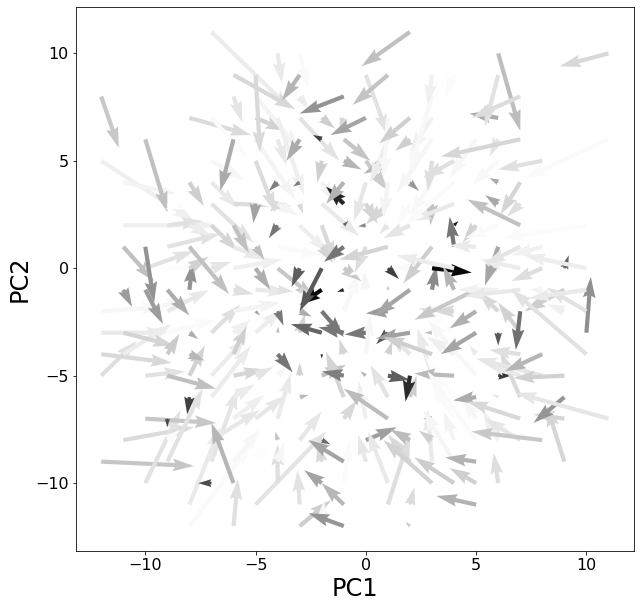

In [50]:
############## plot vectors of PC1/2 transitions shaded by angle to origin #################
# color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
#               'value':list(np.arange(0,180,1))})
color_scale = pd.DataFrame({'color':list(sns.color_palette("gray_r", n_colors=180)),
              'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(np.arange(0,1,1/180)[::-1]),
#               'value':list(np.arange(0,180,1))})


plt.figure(figsize=(10,10))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = angle(current.deltaPC1.mean(), current.deltaPC2.mean(), -x+12, -y+12)
#             print(anglecolor)
            plt.quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = tuple([color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0]]*3))
            
plt.xlabel('PC1', fontsize = 24)
plt.ylabel('PC2', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.savefig(savedir + 'PC1_PC2 Vector map origin angle colored.png', bbox_inches='tight')

In [ ]:
################ IVAN'S SOLUTION TO GETTING ORIENTATION ALONG A LINE ###########
########## BASICALLY FOR EVERY POINT ALONG A LINE, LOOK BACKWARD AND FORWARD A FEW POINTS AND GET THE ANGULAR ORIENTATION OF THAT LINE
def get_direction(subline):
    v = np.linalg.svd(subline - subline.mean(axis=0))[2][0]
    return np.mod(np.arctan2(*v[::-1]),np.pi)

def get_directions(line, avsize=7):
    out = []
    for i,_ in enumerate(line):
        i1 = max(0, i-avsize)
        i2 = i+avsize
        out.append(get_direction(line[i1:i2]))
    return np.array(out)


__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.5+np.log(1+np.arange(0, len(__a__))/len(__a__))

def draw_colorwheel(ax, img, cmap):
    mn = min([img[0,0],img[0,-1], img[-1,0], img[-1,-1]])
    H,W = img.shape

    if img[:35,:40].max() < mn+1:
        ax.scatter(10*__r__*np.cos(__a__)+20, 10*__r__*np.sin(__a__)+25,5,c=np.mod(0.5-__a__/np.pi,1),cmap=cmap)
    elif img[-35:,:40].max() < mn+1:
        ax.scatter(10*__r__*np.cos(__a__)+20, H-25+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cmap)
    elif img[:35,-40:].max() < mn+1:
        ax.scatter(W-20+10*__r__*np.cos(__a__), 25+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cmap)
    elif img[-35:,-40:].max() < mn+1:
        ax.scatter(W-20+10*__r__*np.cos(__a__), H-25+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cmap)

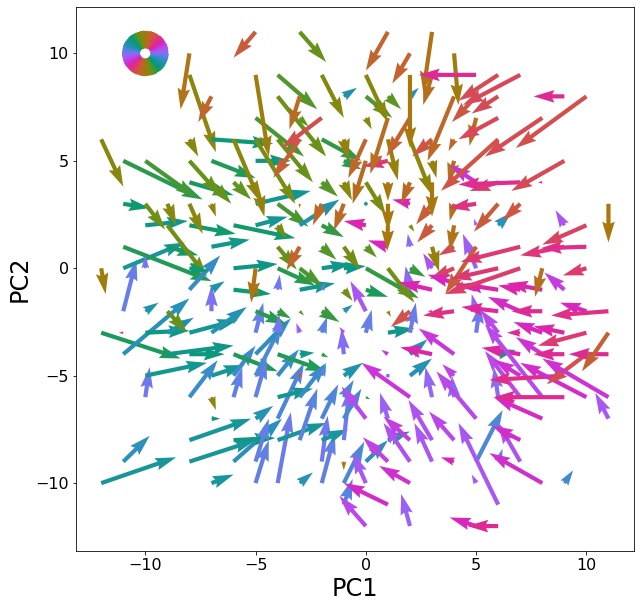

In [386]:
############## plot vectors of PC1/2 transitions shaded by full 360 degree angle #################


from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase


color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(sns.color_palette("gray_r", n_colors=180)),
#               'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(np.arange(0,1,1/180)[::-1]),
#               'value':list(np.arange(0,180,1))})


plt.figure(figsize=(10,10))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.deltaPC1.mean(),current.deltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            plt.quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
plt.xlabel('PC1', fontsize = 24)
plt.ylabel('PC2', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# plt.scatter(10-20+10*__r__*np.cos(__a__), 10+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.scatter(-10+__r__*np.cos(__a__), 10+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'PC1_PC2 Vector map absolute angle colored.png', bbox_inches='tight')
#             print(x,y,current.deltaPC1.mean(), current.deltaPC2.mean(), x+current.deltaPC1.mean(), y+current.deltaPC2.mean())

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 <a list of 7 Text major ticklabel objects>)

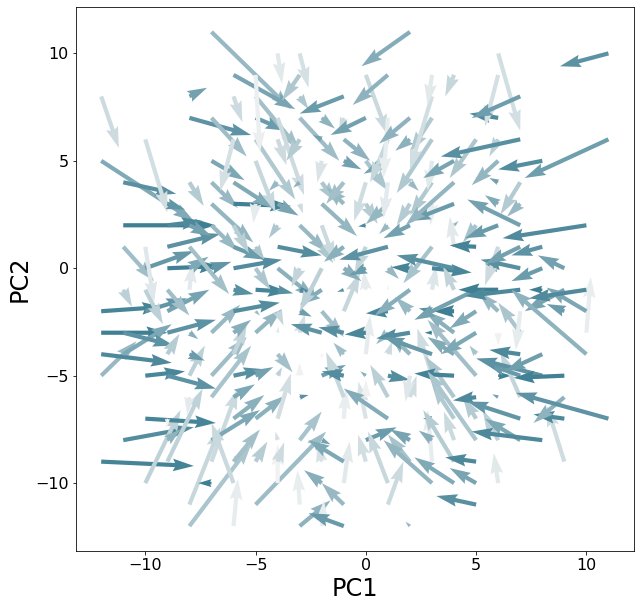

In [248]:
############## plot vectors of PC1/2 transitions shaded by angle to origin #################
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(sns.color_palette("gray_r", n_colors=180)),
#               'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(np.arange(0,1,1/180)[::-1]),
#               'value':list(np.arange(0,180,1))})


plt.figure(figsize=(10,10))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = angle(current.deltaPC1.mean(), current.deltaPC2.mean(), 5, 0)
            if anglecolor > 90:
                anglecolor = abs(anglecolor-180)
#             print(anglecolor)
            plt.quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = tuple([color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0]]*3))
            
plt.xlabel('PC1', fontsize = 24)
plt.ylabel('PC2', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)


#             print(x,y,current.deltaPC1.mean(), current.deltaPC2.mean(), x+current.deltaPC1.mean(), y+current.deltaPC2.mean())

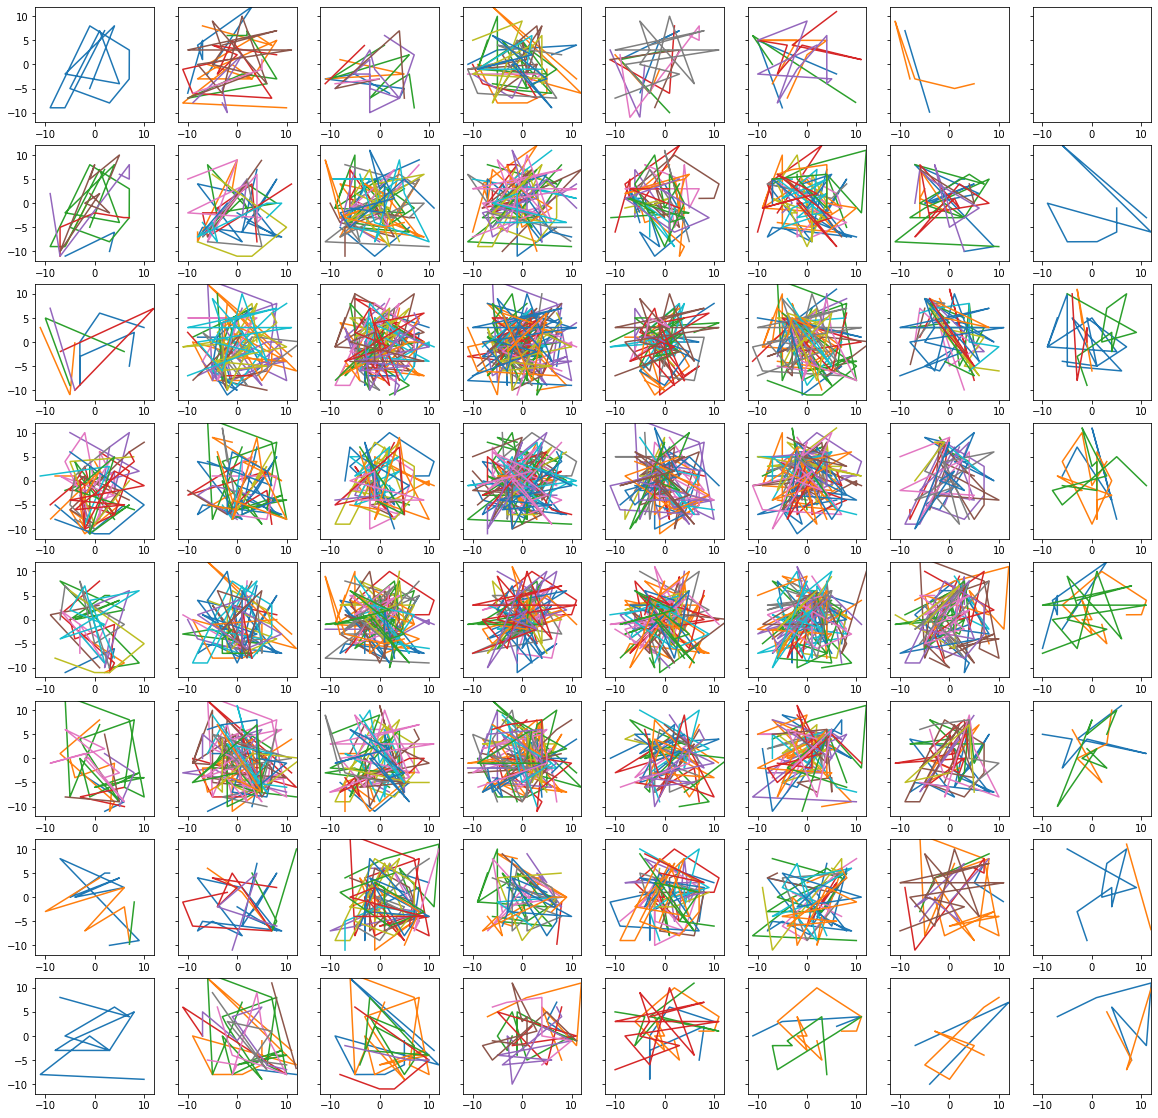

In [233]:
############# grid of plots with pc1/pc2 transitions passing through each "small" bin ###################


from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([TotalFrame.frame.min(),TotalFrame.frame.max()])
cmm = cm.phase


fig, axes = plt.subplots(smallbins,smallbins,figsize=(20,20))

#make numpy array with heatmap data
for x in range(smallbins):
    for y in range(smallbins):
        current = TotalFrame[(TotalFrame['small_PC1deltabins'] == x+1) & (TotalFrame['small_PC2deltabins'] == y+1)]
        if current.empty:
            axes[x,y].set_xlim(-12,12)
            axes[x,y].set_ylim(-12,12)
        else:
            axes[x,y].set_xlim(-12,12)
            axes[x,y].set_ylim(-12,12)
            for c in current.CellID.unique():
                temp = TotalFrame[TotalFrame.CellID == c].sort_values('frame')
                if len(temp)>1:
                    px = temp.PC1deltabins.to_numpy()
                    py = temp.PC2deltabins.to_numpy()
                    pz = temp.frame.to_numpy()
                    dist = np.nansum(scipy.spatial.distance.pdist(temp[['PC1deltabins','PC2deltabins']]))
                    fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
                    newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
                    fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
                    newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
                    fz = scipy.interpolate.interp1d(np.arange(1,len(pz)+1),pz)
                    newz = fz(np.arange(1,len(pz), ((len(pz)+1)-1)/(5*dist)))
                    #actually plot the trajectory
#                     axes[x,y].scatter(newx-12,newy-12, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
                    axes[x,y].plot(newx-12,newy-12)#, color = cmm(norm(newz)), alpha = 0.2), edgecolors='none')



IndexError: index 10 is out of bounds for axis 1 with size 10

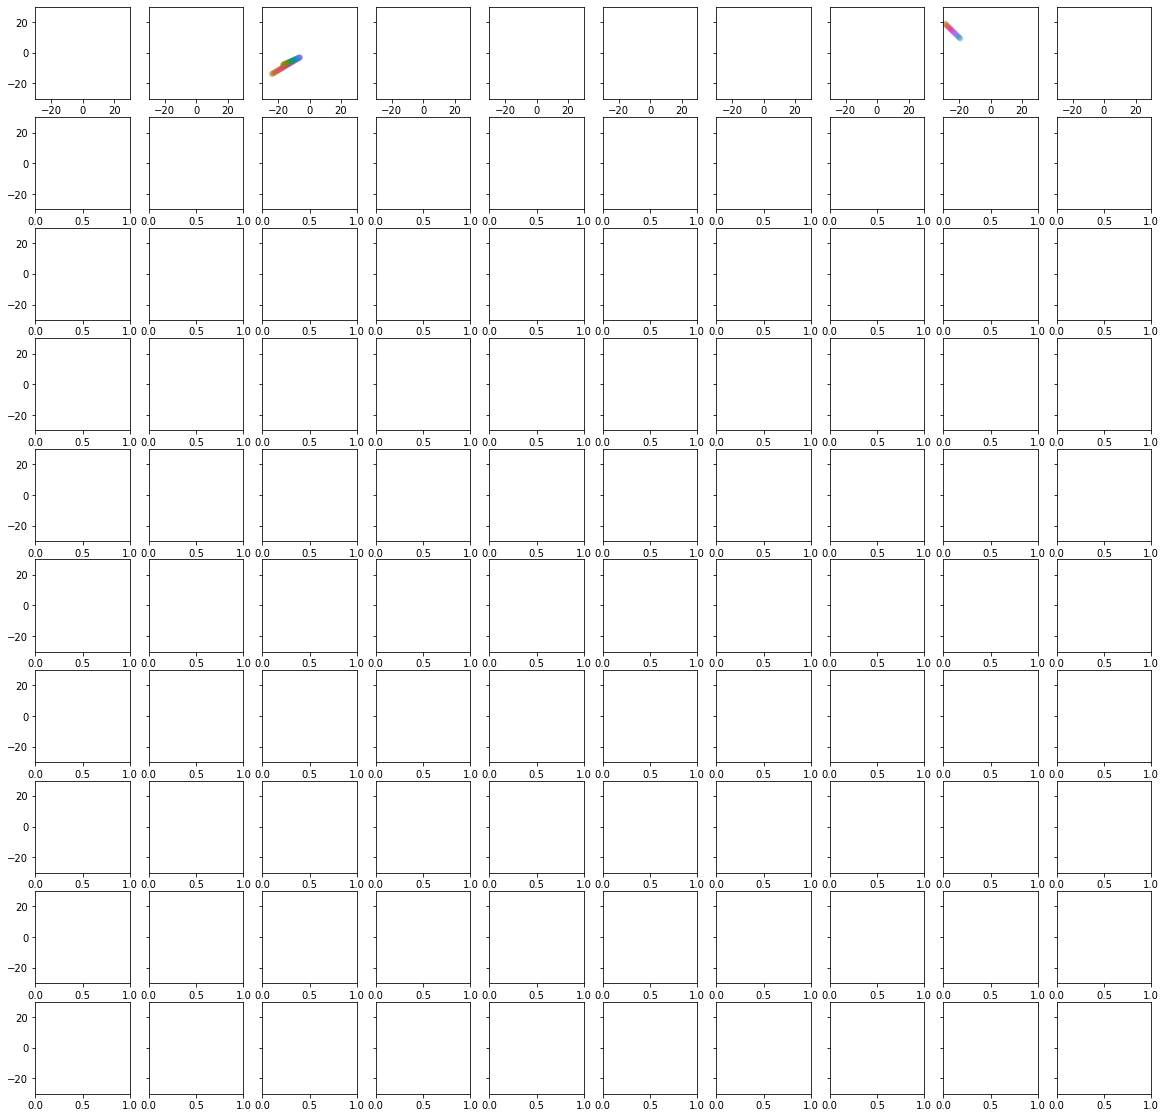

In [68]:
############# grid of plots with pc1/pc2 transitions passing through each "small" bin but only 3 timepoints ###################


#how many timepoints to plot
ntime = 3
#how many cells to plot
ncells = 5



from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([0,ntime])
cmm = cm.phase



fig, axes = plt.subplots(zsmallbins,zsmallbins,figsize=(20,20), sharey=True)

#make numpy array with heatmap data
for x in range(zsmallbins+1):
    for y in range(zsmallbins+1):
        current = TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1) & (TotalFrame['zsmall_PC2deltabins'] == y+1)]
        if current.empty:
            pass
            axes[x,y].set_xlim(-30,30)
            axes[x,y].set_ylim(-30,30)
        else:
            axes[x,y].set_xlim(-30,30)
            axes[x,y].set_ylim(-30,30)
            sample = list(current.CellID.unique())
            if len(sample)>ncells:
                sample = random.sample(list(current.CellID.unique()), ncells)
            for c in sample:
                temp = TotalFrame[TotalFrame.CellID == c].sort_values('frame')
                temp = temp[temp.frame >= current[current.CellID ==c].frame.values[0]]
                temp = temp[~temp['zdeltaPC1'].isna()]
            #     if len(temp)>1 and len(temp)<3:
            #         d
            #     if len(temp)>1 and len(temp)>=3:
                if len(temp)>1:
                    temp = temp[:ntime]
                    px = temp.zPC1deltabins.to_numpy()
                    py = temp.zPC2deltabins.to_numpy()
                    pz = temp.frame.to_numpy()
                    dist = np.nansum(scipy.spatial.distance.pdist(temp[['zPC1deltabins','zPC2deltabins']]))
                    fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
                    newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
                    fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
                    newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
                    newz = np.arange(0,len(temp), len(temp)/len(newy))
                    if len(newz)>len(newy):
                        newz = newz[:-1]
                    #actually plot the trajectory
                    axes[x,y].scatter(newx-30,newy-30, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')

In [67]:
TotalFrame.zsmall_PC1deltabins.max(), list(range(zsmallbins))

(11, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [37]:
len(newy)

49

<Figure size 720x720 with 0 Axes>

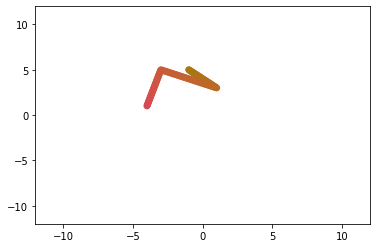

<Figure size 720x720 with 0 Axes>

In [209]:
from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([TotalFrame.frame.min(),TotalFrame.frame.max()])
cmm = cm.phase

temp = TotalFrame[TotalFrame.CellID == c].sort_values('frame')
px = temp.PC1deltabins.to_numpy()
py = temp.PC2deltabins.to_numpy()
pz = temp.frame.to_numpy()
f = scipy.interpolate.interp2d(px, py, pz)
dist = np.nansum(scipy.spatial.distance.pdist(temp[['deltaPC1','deltaPC2']]))
fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(8*dist)))
fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(8*dist)))
fz = scipy.interpolate.interp1d(np.arange(1,len(pz)+1),pz)
newz = fz(np.arange(1,len(pz), ((len(pz)+1)-1)/(8*dist)))
plt.scatter(newx-12,newy-12, color = cmm(norm(newz)))
plt.xlim(-12,12)
plt.ylim(-12,12)
plt.figure(figsize=(10,10))

In [ ]:
############# grid of plots with pc1/pc2 transitions passing through each "small" bin ###################

#make numpy array with heatmap data
bighm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = TotalFrame[(TotalFrame['small_PC1deltabins'] == x+1) & (TotalFrame['small_PC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            p = 0
            for i, c in current.groupby('CellID'):
                p = p + len(c)/len(TotalFrame[TotalFrame.CellID == c.CellID.values[0]])
            
            bighm[y,x] = p
#normalize to number of cells
bighm = bighm/len(TotalFrame.CellID.unique())


#comparison of CELL features
fig, ax = plt.subplots(figsize=(smallbins/2,smallbins/2))
ax = sns.heatmap(
    bighm, 
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    cbar_kws={'shrink': 0.82}
)

ax.set_yticks(np.array(range(0,smallbins+1)))
ax.set_xticks(np.array(range(0,smallbins+1)))
ax.set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)

lab = [0, round(9/2), smallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22, labelpad = -8)       

cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
ax.invert_yaxis()


plt.savefig(savedir + 'PC1_PC2 space pdf.png', bbox_inches='tight')

In [302]:
len(TotalFrame[TotalFrame.CellID == c.CellID.values[0]])

4

In [234]:
len(c.pexit.dropna())

0

In [60]:
sns.color_palette("Blues", n_colors=20)

[(0.9317185697808535, 0.9606920415224913, 0.9881891580161476),
 (0.8948096885813149, 0.9370703575547865, 0.9763783160322953),
 (0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
 (0.7875432525951558, 0.8662053056516724, 0.9409457900807382),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.6718954248366014, 0.8143790849673203, 0.9006535947712418),
 (0.6109803921568627, 0.7874202229911572, 0.8804921184159938),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.46039215686274515, 0.7047443291041907, 0.8480123029603999),
 (0.38682045367166473, 0.6599615532487505, 0.8264206074586697),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.265759323337178, 0.5772856593617839, 0.7791772395232603),
 (0.21568627450980393, 0.5294117647058824, 0.7542483660130719),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.11787773933102653, 0.4283737024221453, 0.6982698961937717),
 (0.0809688581314879, 0.38113033448673583, 0.661361014994233),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944),
 (0.03137254901960784, 0.28567474048442904, 0.5642906574394464),
 (0.03137254901960784, 0.23695501730103807, 0.4919492502883507)]

In [45]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


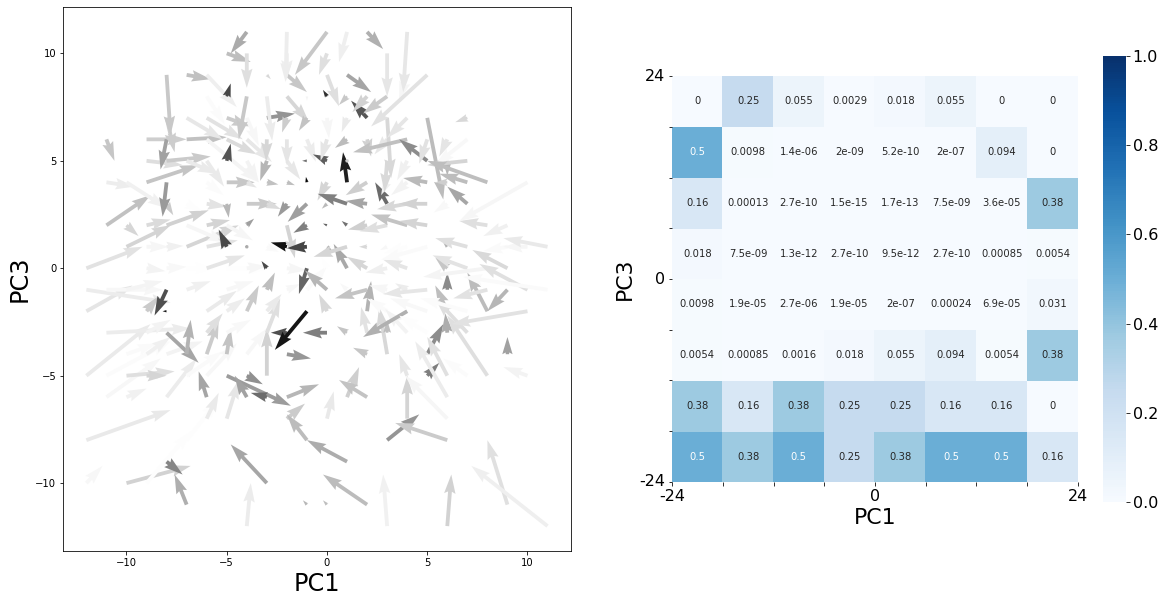

In [204]:
############## plot vectors of PC1/3 transitions shaded by angle to origin #################

# color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
#               'value':list(np.arange(0,180,1))})
color_scale = pd.DataFrame({'color':list(sns.color_palette("gray_r", n_colors=180)),
              'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(np.arange(0,1,1/180)[::-1]),
#               'value':list(np.arange(0,180,1))})

fig, axes = plt.subplots(1, 2, figsize=(20,10))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC3deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = angle(current.deltaPC1.mean(), current.deltaPC3.mean(), -x+12, -y+12)
#             print(anglecolor)
            axes[0].quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC3.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = tuple([color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0]]*3))
            
axes[0].set_xlabel('PC1', fontsize = 24)
axes[0].set_ylabel('PC3', fontsize = 24)
# axes[0].set_xticklabels(axes[0].xaxis.get_ticklabels(),fontsize = 16)
# axes[0].set_yticklabels(axes[0].yaxis.get_ticklabels(),fontsize = 16)



###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = TotalFrame[(TotalFrame['small_PC1deltabins'] == x+1) & (TotalFrame['small_PC3deltabins'] == y+1)]
        if current.empty or np.isnan(current.small_deltaPC1.mean()):
            totalbps.append({'PC1': x,
                          'PC3': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['small_deltaPC1','small_deltaPC3']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'PC1': x,
                              'PC3': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features

axes[1] = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'shrink': 0.82}
)

axes[1].set_yticks(np.array(range(0,smallbins+1)))
axes[1].set_xticks(np.array(range(0,smallbins+1)))
axes[1].set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
axes[1].set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(9/2), smallbins]
for i, l in enumerate(axes[1].xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(axes[1].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
axes[1].set_xlabel('PC1', fontsize = 22)
axes[1].set_ylabel('PC3', fontsize = 22)           

cbar = axes[1].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[1].invert_yaxis()


C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


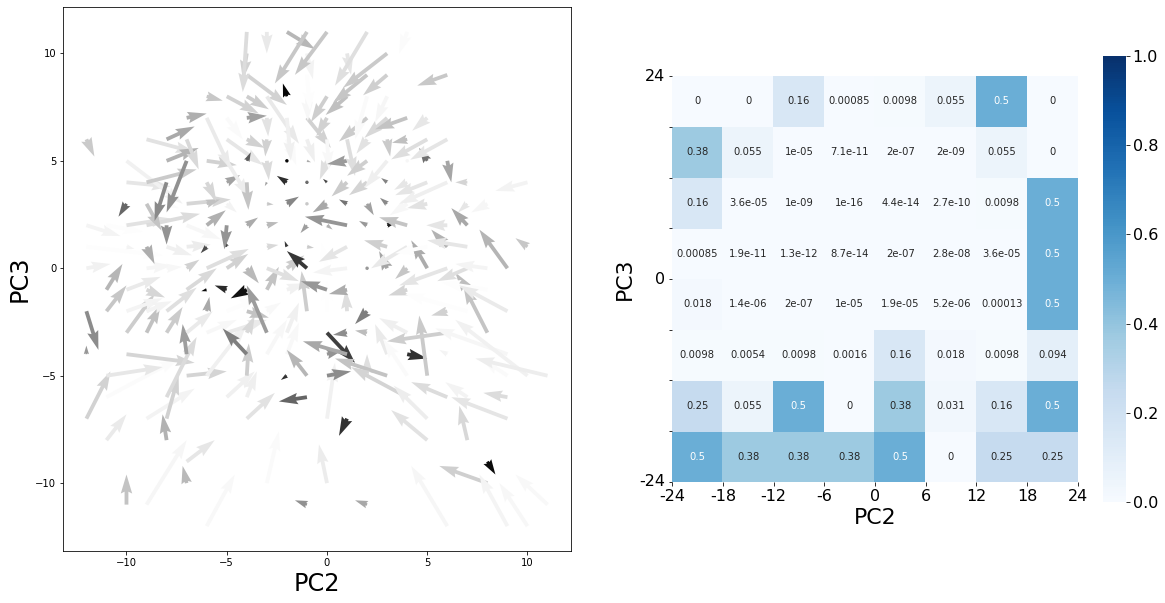

In [206]:
############## plot vectors of PC2/3 transitions shaded by angle to origin #################


# color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
#               'value':list(np.arange(0,180,1))})
color_scale = pd.DataFrame({'color':list(sns.color_palette("gray_r", n_colors=180)),
              'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(np.arange(0,1,1/180)[::-1]),
#               'value':list(np.arange(0,180,1))})

fig, axes = plt.subplots(1, 2, figsize=(20,10))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC2deltabins'] == x+1) & (TotalFrame['PC3deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = angle(current.deltaPC2.mean(), current.deltaPC3.mean(), -x+12, -y+12)
#             print(anglecolor)
            axes[0].quiver(x-12, y-12, 
                       (current.deltaPC2.mean()), (current.deltaPC3.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = tuple([color_scale.loc[color_scale.value == closest(list(color_scale.value), anglecolor)].color.values[0]]*3))
            
axes[0].set_xlabel('PC2', fontsize = 24)
axes[0].set_ylabel('PC3', fontsize = 24)
# axes[0].set_xticklabels(axes[0].xaxis.get_ticklabels(),fontsize = 16)
# axes[0].set_yticklabels(axes[0].yaxis.get_ticklabels(),fontsize = 16)


###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = TotalFrame[(TotalFrame['small_PC2deltabins'] == x+1) & (TotalFrame['small_PC3deltabins'] == y+1)]
        if current.empty or np.isnan(current.small_deltaPC2.mean()):
            totalbps.append({'PC2': x,
                          'PC3': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['small_deltaPC2','small_deltaPC3']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'PC2': x,
                              'PC3': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features

axes[1] = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'shrink': 0.82}
)

axes[1].set_yticks(np.array(range(0,smallbins+1)))
axes[1].set_xticks(np.array(range(0,smallbins+1)))
axes[1].set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
lab = [0, round(9/2), smallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
axes[1].set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)
for i, l in enumerate(axes[1].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
axes[1].set_xlabel('PC2', fontsize = 22)
axes[1].set_ylabel('PC3', fontsize = 22)           

cbar = axes[1].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[1].invert_yaxis()


In [604]:
############## simulating  random transitions ONE TIME ############

#get frames that have data in the next time point and get the delta of PC1 and PC2 bins


#scramble bin locations in each frame
scrlist = []
scrambleframe = TotalFrame[['CellID', 'frame']].copy()
for x, row in TotalFrame[['PC1deltabins','PC2deltabins','PC3deltabins','small_PC1deltabins','small_PC2deltabins','small_PC3deltabins']].iterrows():
       scrlist.append(row.to_list())
random.shuffle(scrlist)
scrambleframe['PC1deltabins'] = [x[0] for x in scrlist]
scrambleframe['PC2deltabins'] = [x[1] for x in scrlist]
scrambleframe['PC3deltabins'] = [x[2] for x in scrlist]
scrambleframe['small_PC1deltabins'] = [x[3] for x in scrlist]
scrambleframe['small_PC2deltabins'] = [x[4] for x in scrlist]
scrambleframe['small_PC3deltabins'] = [x[5] for x in scrlist]


simdf = []
for i, cell in scrambleframe.groupby('CellID'):
    cell = cell.sort_values('frame')
    diffs = cell.frame.diff(periods=-1)
    x=0
    for c, row in cell.iterrows():
        if diffs.loc[c] == -1:
            row['deltaPC1'] = cell.iloc[x+1].PC1deltabins - cell.iloc[x].PC1deltabins
            row['deltaPC2'] = cell.iloc[x+1].PC2deltabins - cell.iloc[x].PC2deltabins
            row['deltaPC3'] = cell.iloc[x+1].PC3deltabins - cell.iloc[x].PC3deltabins
            row['deltamag12'] = sqrt(row['deltaPC1']**2 + row['deltaPC2']**2)
            row['deltamag13'] = sqrt(row['deltaPC1']**2 + row['deltaPC3']**2)
            row['deltamag23'] = sqrt(row['deltaPC2']**2 + row['deltaPC3']**2)
            row['cell'] = row.name
            
            

            row['small_deltaPC1'] = cell.iloc[x+1].small_PC1deltabins - cell.iloc[x].small_PC1deltabins
            row['small_deltaPC2'] = cell.iloc[x+1].small_PC2deltabins - cell.iloc[x].small_PC2deltabins
            row['small_deltaPC3'] = cell.iloc[x+1].small_PC3deltabins - cell.iloc[x].small_PC3deltabins
            #check if cell didn't move in the 2D PC space
            if (cell.iloc[x+1].small_PC1deltabins == cell.iloc[x].small_PC1deltabins
                and cell.iloc[x+1].small_PC2deltabins == cell.iloc[x].small_PC2deltabins):
                row['pstay'] = 1
                row['pexit'] = 0
            elif abs(row.small_deltaPC1)>0 or abs(row.small_deltaPC2)>0:
                row['pstay'] = 0
                row['pexit'] = 1 
            simdf.append(row.to_dict())
        x+=1
        

        
#make into a dataframe
singleframe = pd.DataFrame(simdf)
singleframe.index = singleframe.cell

#add to existing bigger dataframe
scrambleframe = scrambleframe.merge(singleframe[['deltaPC1','deltaPC2', 'deltaPC3', 'deltamag12',
                                         'deltamag13', 'deltamag23', 'small_deltaPC1', 'small_deltaPC2',
                                               'small_deltaPC3', 'pstay', 'pexit']],
                              left_index = True, right_index = True, how = 'outer')


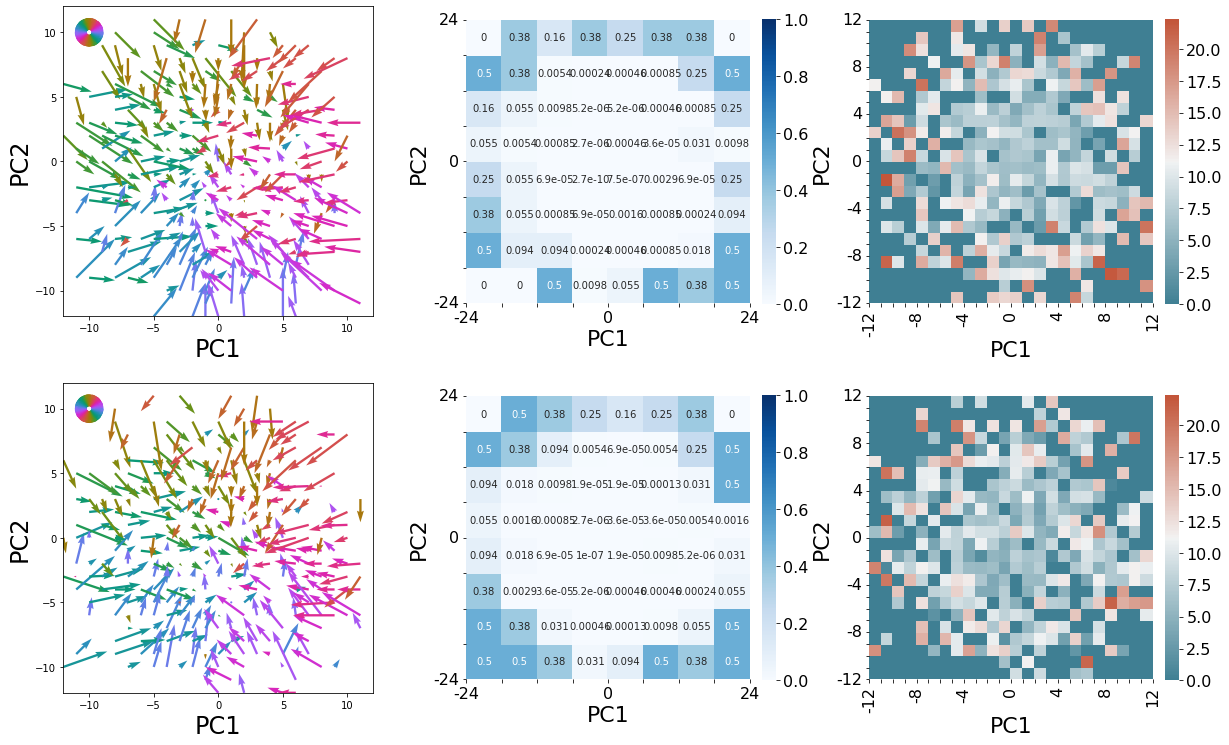

In [607]:
############## plot ONE TIME SIMULATED vectors of PC1/2 transitions #################

from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase



fig, axes = plt.subplots(2, 3, figsize=(20,30))
for x in range(nbins):
    for y in range(nbins):
        current = scrambleframe[(scrambleframe['PC1deltabins'] == x+1) & (scrambleframe['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.deltaPC1.mean(),current.deltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            axes[0,0].quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
axes[0,0].set_xlabel('PC1', fontsize = 24)
axes[0,0].set_ylabel('PC2', fontsize = 24)
__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
axes[0,0].scatter(-10+__r__*np.cos(__a__), 10+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
axes[0,0].set_xlim([-12,12])
axes[0,0].set_ylim([-12,12])



###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = scrambleframe[(scrambleframe['small_PC1deltabins'] == x+1) & (scrambleframe['small_PC2deltabins'] == y+1)][['small_deltaPC1','small_deltaPC2']].dropna()
        if current.empty or np.isnan(current.small_deltaPC1.mean()):
            totalbps.append({'PC1': x,
                          'PC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['small_deltaPC1','small_deltaPC2']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'PC1': x,
                              'PC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#actually plot the binomial probabilities

axes[0,1] = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[0,1]
)

axes[0,1].set_yticks(np.array(range(0,smallbins+1)))
axes[0,1].set_xticks(np.array(range(0,smallbins+1)))
axes[0,1].set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
axes[0,1].set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(9/2), smallbins]
for i, l in enumerate(axes[0,1].xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(axes[0,1].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
axes[0,1].set_xlabel('PC1', fontsize = 22)
axes[0,1].set_ylabel('PC2', fontsize = 22)           

cbar = axes[0,1].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[0,1].invert_yaxis()





################ heatmap of transition magnitude #############
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
for x in range(nbins):
    for y in range(nbins):
        current = scrambleframe[(scrambleframe['PC1deltabins'] == x+1) & (scrambleframe['PC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        elif np.isnan(current.deltamag12.mean()):
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.deltamag12.mean()

#plot heatmap with seaborn
axes[0,2] = sns.heatmap(
    bighm, 
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[0,2]
)
#set tick labels
axes[0,2].set_yticks(np.array(range(0,nbins+1)))
axes[0,2].set_xticks(np.array(range(0,nbins+1)))
axes[0,2].set_xticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    fontsize = 16
)
axes[0,2].set_yticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(axes[0,2].xaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[0,2].yaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
#set axis titles
axes[0,2].set_xlabel('PC1', fontsize = 22)
axes[0,2].set_ylabel('PC2', fontsize = 22)
# adjust colorbar tick label size
cbar = axes[0,2].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
#correct axis orientations
axes[0,2].invert_yaxis()








######################### ALSO PLOT NORMAL DATA TO COMPARE




for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.deltaPC1.mean(),current.deltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            axes[1,0].quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
axes[1,0].set_xlabel('PC1', fontsize = 24)
axes[1,0].set_ylabel('PC2', fontsize = 24)
__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
axes[1,0].scatter(-10+__r__*np.cos(__a__), 10+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
axes[1,0].set_xlim([-12,12])
axes[1,0].set_ylim([-12,12])



###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = TotalFrame[(TotalFrame['small_PC1deltabins'] == x+1) & (TotalFrame['small_PC2deltabins'] == y+1)][['small_deltaPC1','small_deltaPC2']].dropna()
        if current.empty or np.isnan(current.small_deltaPC1.mean()):
            totalbps.append({'PC1': x,
                          'PC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['small_deltaPC1','small_deltaPC2']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'PC1': x,
                              'PC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features

axes[1,1] = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[1,1]
)

axes[1,1].set_yticks(np.array(range(0,smallbins+1)))
axes[1,1].set_xticks(np.array(range(0,smallbins+1)))
axes[1,1].set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
axes[1,1].set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(9/2), smallbins]
for i, l in enumerate(axes[1,1].xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(axes[1,1].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
axes[1,1].set_xlabel('PC1', fontsize = 22)
axes[1,1].set_ylabel('PC2', fontsize = 22)           

cbar = axes[1,1].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[1,1].invert_yaxis()



################ heatmap of transition magnitude #############
#make numpy array with heatmap data
bighm1 = np.zeros((nbins,nbins))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
            bighm1[y,x] = 0
        elif np.isnan(current.deltamag12.mean()):
            bighm1[y,x] = 0
        else:
            bighm1[y,x] = current.deltamag12.mean()

#plot heatmap with seaborn
normalheat = sns.heatmap(
    bighm1, 
    vmin=0, vmax=max(bighm.max(), bighm1.max()), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[1,2]
)
#set tick labels
axes[1,2].set_yticks(np.array(range(0,nbins+1)))
axes[1,2].set_xticks(np.array(range(0,nbins+1)))
axes[1,2].set_xticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    fontsize = 16
)
axes[1,2].set_yticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(axes[1,2].xaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[1,2].yaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
#set axis titles
axes[1,2].set_xlabel('PC1', fontsize = 22)
axes[1,2].set_ylabel('PC2', fontsize = 22)
# adjust colorbar tick label size
cbar = axes[1,2].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
#correct axis orientations
axes[1,2].invert_yaxis()




axes[0,0].set(adjustable='box', aspect='equal')
axes[0,1].set(adjustable='box', aspect='equal')
axes[0,2].set(adjustable='box', aspect='equal')
axes[1,0].set(adjustable='box', aspect='equal')
axes[1,1].set(adjustable='box', aspect='equal')
axes[1,2].set(adjustable='box', aspect='equal')

plt.subplots_adjust(wspace= 0.3,hspace=-0.7)
# fig.tight_layout()

In [551]:
################ scramble bin locations in each frame ONE HUNDRED TIMES ###################
scrlist = []

for x, row in TotalFrame[['PC1deltabins','PC2deltabins','PC3deltabins','small_PC1deltabins','small_PC2deltabins','small_PC3deltabins']].iterrows():
       scrlist.append(row.to_list())

        
    
bigsimdf = []
        
#randomize the bin positions 100 times
for x in range(0,100):
    random.shuffle(scrlist)
    
    scrambleframe = TotalFrame[['CellID', 'frame']].copy()
    scrambleframe['PC1deltabins'] = [x[0] for x in scrlist]
    scrambleframe['PC2deltabins'] = [x[1] for x in scrlist]
    scrambleframe['PC3deltabins'] = [x[2] for x in scrlist]
    scrambleframe['small_PC1deltabins'] = [x[3] for x in scrlist]
    scrambleframe['small_PC2deltabins'] = [x[4] for x in scrlist]
    scrambleframe['small_PC3deltabins'] = [x[5] for x in scrlist]


    for i, cell in scrambleframe.groupby('CellID'):
        cell = cell.sort_values('frame')
        diffs = cell.frame.diff(periods=-1)
        x=0
        for c, row in cell.iterrows():
            if diffs.loc[c] == -1:
                row['deltaPC1'] = cell.iloc[x+1].PC1deltabins - cell.iloc[x].PC1deltabins
                row['deltaPC2'] = cell.iloc[x+1].PC2deltabins - cell.iloc[x].PC2deltabins
                row['deltaPC3'] = cell.iloc[x+1].PC3deltabins - cell.iloc[x].PC3deltabins
                row['deltamag12'] = sqrt(row['deltaPC1']**2 + row['deltaPC2']**2)
                row['deltamag13'] = sqrt(row['deltaPC1']**2 + row['deltaPC3']**2)
                row['deltamag23'] = sqrt(row['deltaPC2']**2 + row['deltaPC3']**2)
                row['cell'] = row.name



                row['small_deltaPC1'] = cell.iloc[x+1].small_PC1deltabins - cell.iloc[x].small_PC1deltabins
                row['small_deltaPC2'] = cell.iloc[x+1].small_PC2deltabins - cell.iloc[x].small_PC2deltabins
                row['small_deltaPC3'] = cell.iloc[x+1].small_PC3deltabins - cell.iloc[x].small_PC3deltabins
                #check if cell didn't move in the 2D PC space
                if (cell.iloc[x+1].small_PC1deltabins == cell.iloc[x].small_PC1deltabins
                    and cell.iloc[x+1].small_PC2deltabins == cell.iloc[x].small_PC2deltabins):
                    row['pstay'] = 1
                    row['pexit'] = 0
                elif abs(row.small_deltaPC1)>0 or abs(row.small_deltaPC2)>0:
                    row['pstay'] = 0
                    row['pexit'] = 1 
                bigsimdf.append(row.to_dict())
            x+=1
            
bigsimdf = pd.DataFrame(bigsimdf)
bigsimdf.index = bigsimdf.cell

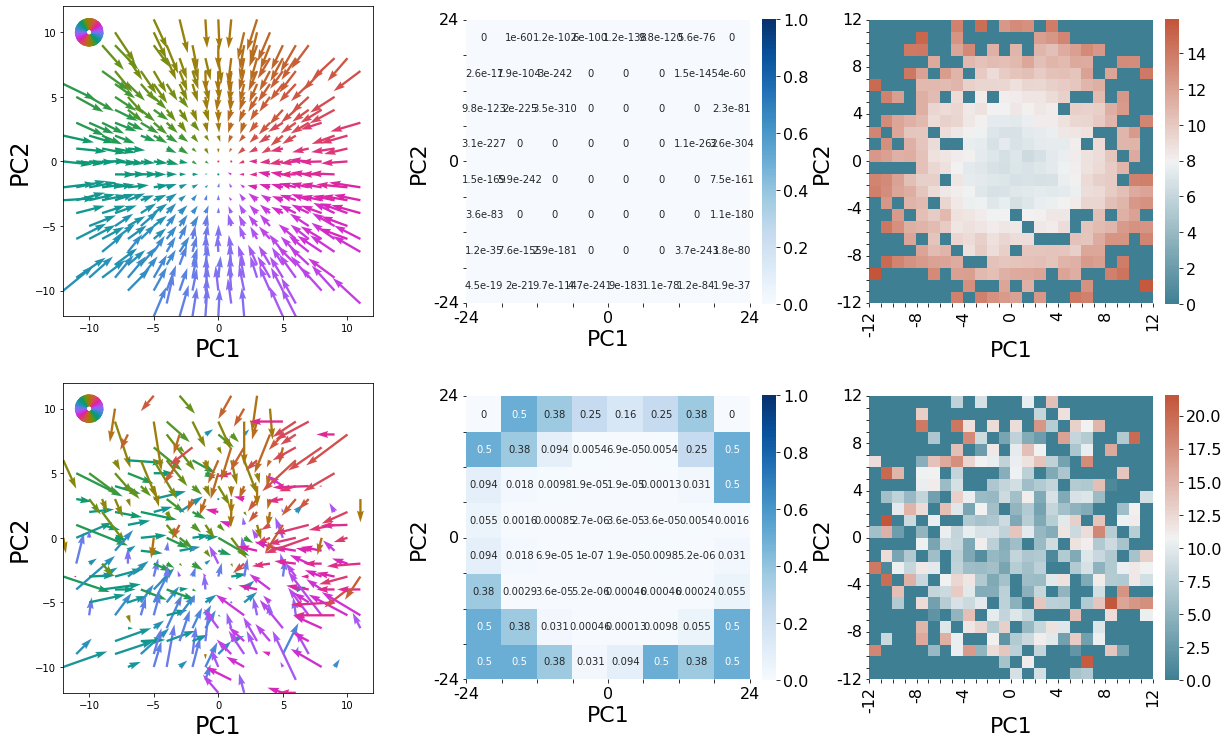

In [608]:
############## plot SIMULATED vectors of PC1/2 transitions 100 SIMULATIONS #################

from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase



fig, axes = plt.subplots(2, 3, figsize=(20,30))
for x in range(nbins):
    for y in range(nbins):
        current = bigsimdf[(bigsimdf['PC1deltabins'] == x+1) & (bigsimdf['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.deltaPC1.mean(),current.deltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            axes[0,0].quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
axes[0,0].set_xlabel('PC1', fontsize = 24)
axes[0,0].set_ylabel('PC2', fontsize = 24)
__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
axes[0,0].scatter(-10+__r__*np.cos(__a__), 10+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
axes[0,0].set_xlim([-12,12])
axes[0,0].set_ylim([-12,12])



###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = bigsimdf[(bigsimdf['small_PC1deltabins'] == x+1) & (bigsimdf['small_PC2deltabins'] == y+1)][['small_deltaPC1','small_deltaPC2']].dropna()
        if current.empty or np.isnan(current.small_deltaPC1.mean()):
            totalbps.append({'PC1': x,
                          'PC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['small_deltaPC1','small_deltaPC2']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)//(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = float(Decimal(nf)*Decimal(0.5**f)*Decimal(0.5**(n-f)))
                totalbps.append({'PC1': x,
                              'PC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#actually plot the binomial probabilities

axes[0,1] = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[0,1]
)

axes[0,1].set_yticks(np.array(range(0,smallbins+1)))
axes[0,1].set_xticks(np.array(range(0,smallbins+1)))
axes[0,1].set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
axes[0,1].set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(9/2), smallbins]
for i, l in enumerate(axes[0,1].xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(axes[0,1].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
axes[0,1].set_xlabel('PC1', fontsize = 22)
axes[0,1].set_ylabel('PC2', fontsize = 22)           

cbar = axes[0,1].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[0,1].invert_yaxis()





################ heatmap of transition magnitude #############
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
for x in range(nbins):
    for y in range(nbins):
        current = bigsimdf[(bigsimdf['PC1deltabins'] == x+1) & (bigsimdf['PC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        elif np.isnan(current.deltamag12.mean()):
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.deltamag12.mean()

#plot heatmap with seaborn
axes[0,2] = sns.heatmap(
    bighm, 
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[0,2]
)
#set tick labels
axes[0,2].set_yticks(np.array(range(0,nbins+1)))
axes[0,2].set_xticks(np.array(range(0,nbins+1)))
axes[0,2].set_xticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    fontsize = 16
)
axes[0,2].set_yticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(axes[0,2].xaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[0,2].yaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
#set axis titles
axes[0,2].set_xlabel('PC1', fontsize = 22)
axes[0,2].set_ylabel('PC2', fontsize = 22)
# adjust colorbar tick label size
cbar = axes[0,2].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
#correct axis orientations
axes[0,2].invert_yaxis()








######################### ALSO PLOT NORMAL DATA TO COMPARE




for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.deltaPC1.mean(),current.deltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            axes[1,0].quiver(x-12, y-12, 
                       (current.deltaPC1.mean()), (current.deltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
axes[1,0].set_xlabel('PC1', fontsize = 24)
axes[1,0].set_ylabel('PC2', fontsize = 24)
__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
axes[1,0].scatter(-10+__r__*np.cos(__a__), 10+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
axes[1,0].set_xlim([-12,12])
axes[1,0].set_ylim([-12,12])



###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((smallbins,smallbins))
for x in range(smallbins):
    for y in range(smallbins):
        current = TotalFrame[(TotalFrame['small_PC1deltabins'] == x+1) & (TotalFrame['small_PC2deltabins'] == y+1)][['small_deltaPC1','small_deltaPC2']].dropna()
        if current.empty or np.isnan(current.small_deltaPC1.mean()):
            totalbps.append({'PC1': x,
                          'PC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['small_deltaPC1','small_deltaPC2']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'PC1': x,
                              'PC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features

axes[1,1] = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[1,1]
)

axes[1,1].set_yticks(np.array(range(0,smallbins+1)))
axes[1,1].set_xticks(np.array(range(0,smallbins+1)))
axes[1,1].set_xticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    fontsize = 16
)
axes[1,1].set_yticklabels(
    np.linspace(-nbins, nbins, 9,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(9/2), smallbins]
for i, l in enumerate(axes[1,1].xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(axes[1,1].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
axes[1,1].set_xlabel('PC1', fontsize = 22)
axes[1,1].set_ylabel('PC2', fontsize = 22)           

cbar = axes[1,1].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[1,1].invert_yaxis()



################ heatmap of transition magnitude #############
#make numpy array with heatmap data
bighm1 = np.zeros((nbins,nbins))
for x in range(nbins):
    for y in range(nbins):
        current = TotalFrame[(TotalFrame['PC1deltabins'] == x+1) & (TotalFrame['PC2deltabins'] == y+1)]
        if current.empty:
            bighm1[y,x] = 0
        elif np.isnan(current.deltamag12.mean()):
            bighm1[y,x] = 0
        else:
            bighm1[y,x] = current.deltamag12.mean()

#plot heatmap with seaborn
normalheat = sns.heatmap(
    bighm1, 
    vmin=0, vmax=max(bighm.max(), bighm1.max()), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[1,2]
)
#set tick labels
axes[1,2].set_yticks(np.array(range(0,nbins+1)))
axes[1,2].set_xticks(np.array(range(0,nbins+1)))
axes[1,2].set_xticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    fontsize = 16
)
axes[1,2].set_yticklabels(
    np.linspace(-nbins/2, nbins/2, nbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(axes[1,2].xaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[1,2].yaxis.get_ticklabels()):
    if i%4 != 0:
        l.set_visible(False)
#set axis titles
axes[1,2].set_xlabel('PC1', fontsize = 22)
axes[1,2].set_ylabel('PC2', fontsize = 22)
# adjust colorbar tick label size
cbar = axes[1,2].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
#correct axis orientations
axes[1,2].invert_yaxis()




axes[0,0].set(adjustable='box', aspect='equal')
axes[0,1].set(adjustable='box', aspect='equal')
axes[0,2].set(adjustable='box', aspect='equal')
axes[1,0].set(adjustable='box', aspect='equal')
axes[1,1].set(adjustable='box', aspect='equal')
axes[1,2].set(adjustable='box', aspect='equal')

plt.subplots_adjust(wspace= 0.3,hspace=-0.7)
# fig.tight_layout()

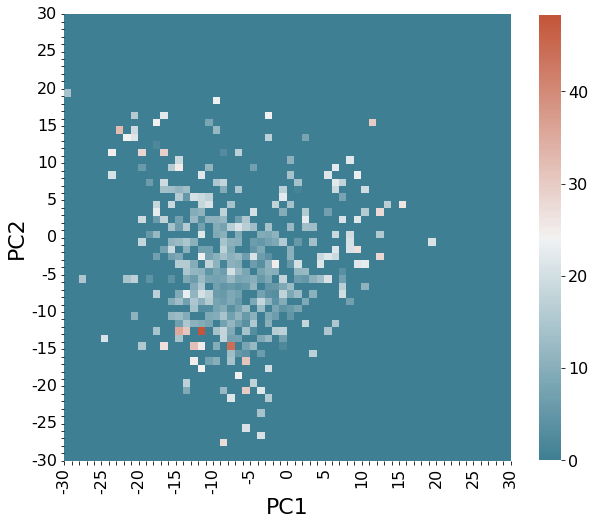

In [672]:
################ heatmap of transition magnitude #############
#make numpy array with heatmap data
bighm = np.zeros((znbins,znbins))
for x in range(znbins):
    for y in range(znbins):
        current =  TotalFrame[(TotalFrame['zPC1deltabins'] == x+1) & (TotalFrame['zPC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        elif np.isnan(current.zdeltamag12.mean()):
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.zdeltamag12.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(znbins//6,znbins//6))
ax = sns.heatmap(
    bighm, 
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
#set tick labels
ax.set_yticks(np.array(range(0,znbins+1)))
ax.set_xticks(np.array(range(0,znbins+1)))
ax.set_xticklabels(
    np.linspace(-znbins/2, znbins/2, znbins+1,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-znbins/2, znbins/2, znbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
#correct axis orientations
ax.invert_yaxis()

plt.savefig(savedir + 'zPC1_PC2 transition magnitude heatmap.png', bbox_inches='tight')

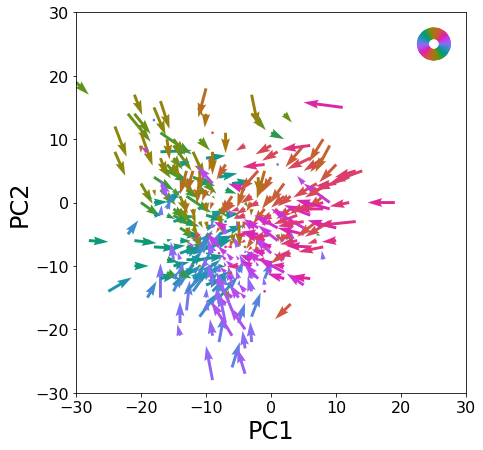

In [656]:
############## plot vectors of PC1/2 transitions shaded by full 360 degree angle #################


from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase


color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(sns.color_palette("gray_r", n_colors=180)),
#               'value':list(np.arange(0,180,1))})
# color_scale = pd.DataFrame({'color':list(np.arange(0,1,1/180)[::-1]),
#               'value':list(np.arange(0,180,1))})

plt.figure(figsize=(7,7))
for x in range(znbins):
    for y in range(znbins):
        current = TotalFrame[(TotalFrame['zPC1deltabins'] == x+1) & (TotalFrame['zPC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.zdeltaPC1.mean(),current.zdeltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            plt.quiver(x-30, y-30, 
                       (current.zdeltaPC1.mean()), (current.zdeltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
plt.xlabel('PC1', fontsize = 24)
plt.ylabel('PC2', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(-30,30)
plt.xlim(-30,30)

#color wheel stuff
__a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
__r__=0.5+np.log(1+np.arange(0, len(__a__))/len(__a__))
# plt.scatter(10-20+10*__r__*np.cos(__a__), 10+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.scatter(25+2*__r__*np.cos(__a__), 25+2*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'zPC1_PC2 Vector map absolute angle colored.png', bbox_inches='tight')

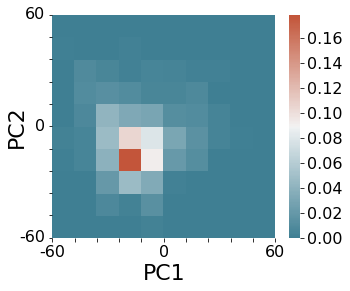

In [62]:
############# pdf of PC1/PC2 positions normalized to individual cells ###################

#make numpy array with heatmap data
bighm = np.zeros((zsmallbins,zsmallbins))
for x in range(zsmallbins):
    for y in range(zsmallbins):
        current = TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1) & (TotalFrame['zsmall_PC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            p = 0
            for i, c in current.groupby('CellID'):
                p = p + len(c)/len(TotalFrame[TotalFrame.CellID == c.CellID.values[0]])
            
            bighm[y,x] = p
#normalize to number of cells
bighm = bighm/len(TotalFrame.CellID.unique())


#comparison of CELL features
fig, ax = plt.subplots(figsize=(zsmallbins/2,zsmallbins/2))
ax = sns.heatmap(
    bighm, 
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    cbar_kws={'shrink': 0.82}
)

ax.set_yticks(np.array(range(0,zsmallbins+1)))
ax.set_xticks(np.array(range(0,zsmallbins+1)))
ax.set_xticklabels(
    np.linspace(-znbins, znbins, 11,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-znbins, znbins, 11,dtype = int),
    rotation=0,
    fontsize = 16
)

lab = [0, round(10/2), zsmallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22, labelpad = -8)       

cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
ax.invert_yaxis()


# plt.savefig(savedir + 'zPC1_PC2 space pdf.png', bbox_inches='tight')

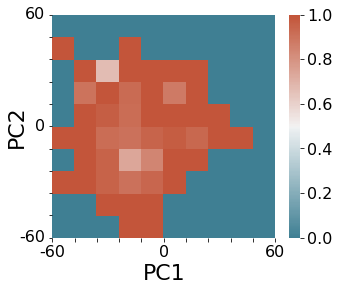

In [686]:
###################### pexit probability normalized to individual cells in bins "mean" test ####################
#make numpy array with heatmap data
bighm = np.zeros((zsmallbins,zsmallbins))
for x in range(zsmallbins):
    for y in range(zsmallbins):
        current = TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1) & (TotalFrame['zsmall_PC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            p = []
            for i, c in current.groupby('CellID'):
                #only append values if there are no nan values
                if len(c.zpexit.dropna()) > 0:
                    p.append(c.zpexit.sum()/len(c))
            #if the only value is nan value this will not append to p so make p 0
            if len(p) ==0:
                p=0
            bighm[y,x] = np.array(p).mean()

#comparison of CELL features
fig, ax = plt.subplots(figsize=(zsmallbins/2,zsmallbins/2))
ax = sns.heatmap(
    bighm, 
    vmin=0, vmax=1, #bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    cbar_kws={'shrink': 0.82}
)

ax.set_yticks(np.array(range(0,zsmallbins+1)))
ax.set_xticks(np.array(range(0,zsmallbins+1)))
ax.set_xticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)

lab = [0, round(10/2), zsmallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
        
#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22, labelpad = -8)       
         

cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
ax.invert_yaxis()

plt.savefig(savedir + 'zPC1_PC2 space pexit.png', bbox_inches='tight')

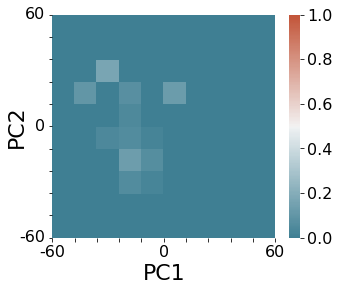

In [688]:
###################### pstay probability ####################
#make numpy array with heatmap data
bighm = np.zeros((zsmallbins,zsmallbins))
for x in range(zsmallbins):
    for y in range(zsmallbins):
        current = TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1) & (TotalFrame['zsmall_PC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            p = []
            for i, c in current.groupby('CellID'):
                #only append values if there are no nan values
                if len(c.zpexit.dropna()) > 0:
                    p.append(c.zpstay.sum()/len(c))
            #if the only value is nan value this will not append to p so make p 0
            if len(p) ==0:
                p=0
            bighm[y,x] = np.array(p).mean()
            
            bighm[y,x] = np.array(p).mean()
#normalize to number of cells
# bighm = bighm/len(TotalFrame.CellID.unique())


#comparison of CELL features
fig, ax = plt.subplots(figsize=(zsmallbins/2,zsmallbins/2))
ax = sns.heatmap(
    bighm, 
    vmin=0, vmax=1, #bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    cbar_kws={'shrink': 0.82}
)

ax.set_yticks(np.array(range(0,zsmallbins+1)))
ax.set_xticks(np.array(range(0,zsmallbins+1)))
ax.set_xticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(zsmallbins/2), zsmallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)

#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22, labelpad = -8)   
        
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
ax.invert_yaxis()

plt.savefig(savedir + 'zPC1_PC2 space pstay.png', bbox_inches='tight')

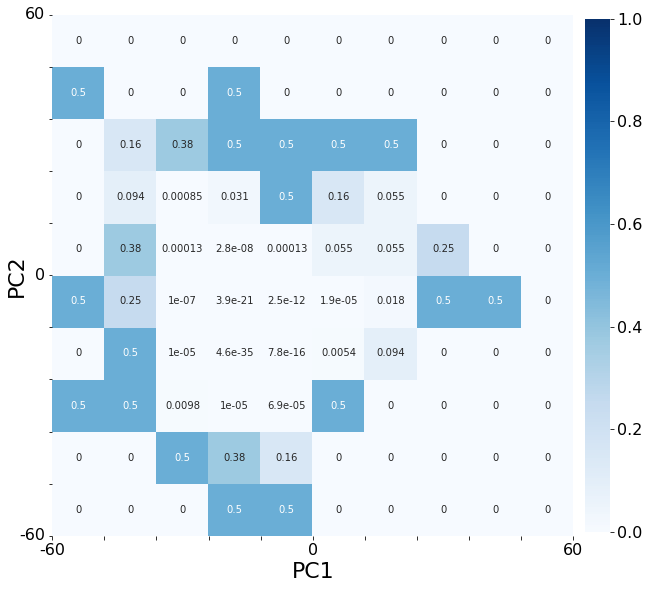

In [738]:
###################### bionomial probabilities FOR Z SCORED PCs ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((zsmallbins,zsmallbins))
for x in range(zsmallbins):
    for y in range(zsmallbins):
        current = TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1) & (TotalFrame['zsmall_PC2deltabins'] == y+1)][['zsmall_deltaPC1','zsmall_deltaPC2']].dropna()
        if current.empty or np.isnan(current.zsmall_deltaPC1.mean()):
            totalbps.append({'zPC1': x,
                          'zPC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['zsmall_deltaPC1','zsmall_deltaPC2']):
                #number of transitions
                n = len(current)
                #number of ways that specific transition happened
                f = len(c)
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'zPC1': x,
                              'zPC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features
fig, ax = plt.subplots(figsize=(zsmallbins,zsmallbins))
ax = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.02}
)


ax.set_yticks(np.array(range(0,zsmallbins+1)))
ax.set_xticks(np.array(range(0,zsmallbins+1)))
ax.set_xticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(zsmallbins/2), zsmallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)

        
#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22, labelpad = -8)           

cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
ax.invert_yaxis()


# plt.savefig(savedir + 'zPC1_PC2 binomial probabilities.png', bbox_inches='tight')

In [751]:
###### look at the individual probabilities for a given bin #########
totalbps[(totalbps.zPC1==3) & (totalbps.zPC2==4)]


zPC1  zPC2  Binomial_Probability
146     3     4          3.917527e-21
147     3     4          3.917527e-21
148     3     4          3.917527e-21
149     3     4          3.917527e-21
150     3     4          3.431754e-18
151     3     4          8.527909e-16
152     3     4          3.917527e-21
153     3     4          3.917527e-21
154     3     4          9.656229e-08
155     3     4          5.851100e-12
156     3     4          8.527909e-16
157     3     4          3.917527e-21
158     3     4          3.917527e-21
159     3     4          3.431754e-18
160     3     4          3.803215e-11
161     3     4          1.429897e-19
162     3     4          1.429897e-19
163     3     4          3.917527e-21
164     3     4          3.917527e-21
165     3     4          3.917527e-21
166     3     4          3.431754e-18
167     3     4          1.429897e-19
168     3     4          1.429897e-19
169     3     4          1.429897e-19

Text(0.5, 0, 'time (min)')

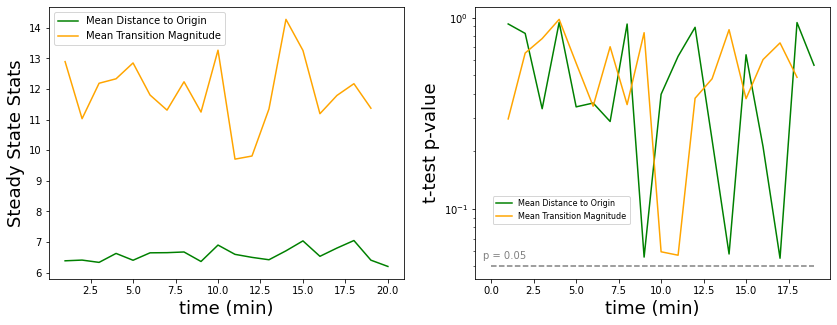

In [753]:
######### get steady state metrics for z scored PCs ############

dto = []
tmag = []
cellperframe = []

dto_ttest = []
tmag_ttest = []
for t, time in TotalFrame.groupby('frame'):
    time['distancetoorigin'] = np.sqrt(time.zsmall_PC1deltabins.to_numpy()**2 + time.zsmall_PC2deltabins.to_numpy()**2)
    #append average distance to origin at this time point
    dto.append(time.distancetoorigin.mean())
    #append average magnitude of transition
    tmag.append(time.zdeltamag12.mean())
    cellperframe.append(len(time))
    if t == TotalFrame.frame.min():
        tzero = time.copy()
    else:
        dto_ttest.append(scipy.stats.ttest_ind(a=tzero.distancetoorigin, b=time.distancetoorigin, equal_var=True))
        tmag_ttest.append(scipy.stats.ttest_ind(a=tzero.zdeltamag12.dropna(), b=time.zdeltamag12.dropna(), equal_var=True))

        
fig, axes = plt.subplots(1,2, figsize = (14,5))        

#plot the steady state stats
x = list(range(int(TotalFrame.frame.min()), int(TotalFrame.frame.max())+1))
axes[0].plot(x, dto, 'g', label = 'Mean Distance to Origin')
axes[0].plot(x, tmag, 'orange', label = 'Mean Transition Magnitude')
# axes[0].set_ylim(0,12)
axes[0].legend()
axes[0].set_ylabel('Steady State Stats', size = 18)
axes[0].set_xlabel('time (min)', size = 18)


#plot the t tests 
axes[1].plot(list(range(1,20)),[x[1] for x in dto_ttest], 'g', label = 'Mean Distance to Origin')
axes[1].plot(list(range(1,20)),[x[1] for x in tmag_ttest], 'orange', label = 'Mean Transition Magnitude')
axes[1].plot(list(range(0,20,1)), [0.05]*20, linestyle = 'dashed',color = 'gray')
axes[1].set_yscale("log")
axes[1].text(-0.5, 0.055, 'p = 0.05', color = 'gray')
axes[1].legend(loc = [0.05,0.2], fontsize = 8)
axes[1].set_ylabel('t-test p-value', size = 18)
axes[1].set_xlabel('time (min)', size = 18)

# plt.savefig(savedir + 'zPC1_PC2 space steady state.png', bbox_inches='tight')

In [726]:
################ scramble bin locations in each frame ONE HUNDRED TIMES ###################
scrlist = []

for x, row in TotalFrame[['zPC1deltabins','zPC2deltabins','zsmall_PC1deltabins','zsmall_PC2deltabins']].iterrows():
       scrlist.append(row.to_list())

        
    
bigsimdf = []
        
#randomize the bin positions 100 times
for x in range(0,100):
    random.shuffle(scrlist)
    
    scrambleframe = TotalFrame[['CellID', 'frame']].copy()
    scrambleframe['zPC1deltabins'] = [x[0] for x in scrlist]
    scrambleframe['zPC2deltabins'] = [x[1] for x in scrlist]
    scrambleframe['zsmall_PC1deltabins'] = [x[2] for x in scrlist]
    scrambleframe['zsmall_PC2deltabins'] = [x[3] for x in scrlist]


    for i, cell in scrambleframe.groupby('CellID'):
        cell = cell.sort_values('frame')
        diffs = cell.frame.diff(periods=-1)
        x=0
        for c, row in cell.iterrows():
            if diffs.loc[c] == -1:
                row['zdeltaPC1'] = cell.iloc[x+1].zPC1deltabins - cell.iloc[x].zPC1deltabins
                row['zdeltaPC2'] = cell.iloc[x+1].zPC2deltabins - cell.iloc[x].zPC2deltabins
                row['zdeltamag12'] = sqrt(row['zdeltaPC1']**2 + row['zdeltaPC2']**2)
                row['cell'] = row.name


                row['zsmall_deltaPC1'] = cell.iloc[x+1].zsmall_PC1deltabins - cell.iloc[x].zsmall_PC1deltabins
                row['zsmall_deltaPC2'] = cell.iloc[x+1].zsmall_PC2deltabins - cell.iloc[x].zsmall_PC2deltabins

                #check if cell didn't move in the 2D PC space
                if (cell.iloc[x+1].zsmall_PC1deltabins == cell.iloc[x].zsmall_PC1deltabins
                    and cell.iloc[x+1].zsmall_PC2deltabins == cell.iloc[x].zsmall_PC2deltabins):
                    row['zpstay'] = 1
                    row['zpexit'] = 0
                elif abs(row.zsmall_deltaPC1)>0 or abs(row.zsmall_deltaPC2)>0:
                    row['zpstay'] = 0
                    row['zpexit'] = 1 
                bigsimdf.append(row.to_dict())
            x+=1
            
bigsimdf = pd.DataFrame(bigsimdf)
bigsimdf.index = bigsimdf.cell

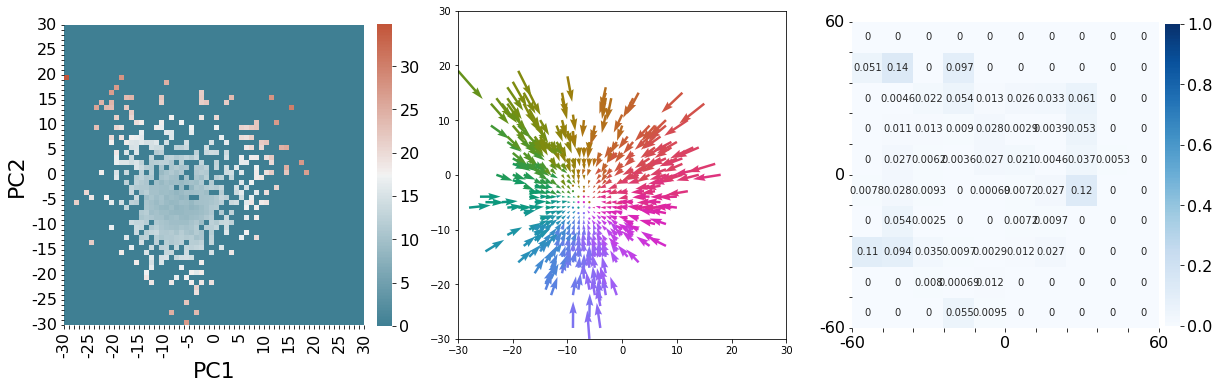

In [31]:
############## plot SIMULATED vectors of PC1/2 transitions 100 SIMULATIONS WITH Z SCORE PCs #################

from cmocean import cm
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase



fig, axes = plt.subplots(1, 3, figsize=(20,30))
for x in range(znbins):
    for y in range(znbins):
        current = bigsimdf[(bigsimdf['zPC1deltabins'] == x+1) & (bigsimdf['zPC2deltabins'] == y+1)]
        if current.empty:
#             plt.plot(x, y, 'k.', markersize=10)
            pass
        else:
            anglecolor = (np.arctan2(current.zdeltaPC1.mean(),current.zdeltaPC2.mean()) *180/np.pi)+180
#             print(anglecolor)
            axes[1].quiver(x-30, y-30, 
                       (current.zdeltaPC1.mean()), (current.zdeltaPC2.mean()),
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = 5,
                      color = cmm(norm(anglecolor)))
            
# axes[1].set_xlabel('PC1', fontsize = 24)
# axes[1].set_ylabel('PC2', fontsize = 24)
# axes[1].set_xticks(fontsize = 16)
# axes[1].set_yticks(fontsize = 16)
axes[1].set_ylim(-30,30)
axes[1].set_xlim(-30,30)



###################### bionomial probabilities ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((zsmallbins,zsmallbins))
for x in range(zsmallbins):
    for y in range(zsmallbins):
        current = bigsimdf[(bigsimdf['zsmall_PC1deltabins'] == x+1) & (bigsimdf['zsmall_PC2deltabins'] == y+1)][['zsmall_deltaPC1','zsmall_deltaPC2']].dropna()
        if current.empty or np.isnan(current.zsmall_deltaPC1.mean()):
            totalbps.append({'zPC1': x,
                          'zPC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0
            
        else:
            minbp = []
            for i, c in current.groupby(['zsmall_deltaPC1','zsmall_deltaPC2']):
                #forward transitions
                f = len(c)
                #reverse transitions
                r = len(bigsimdf[(bigsimdf['zsmall_PC1deltabins'] == x+1+c.zsmall_deltaPC1[0])
                   & (bigsimdf['zsmall_PC2deltabins'] == y+1+c.zsmall_deltaPC2[0])
                  & (bigsimdf['zsmall_deltaPC1'] == c.zsmall_deltaPC1[0]*-1)
                  & (bigsimdf['zsmall_deltaPC2'] == c.zsmall_deltaPC2[0]*-1)][['zsmall_PC1deltabins','zsmall_PC2deltabins','zsmall_deltaPC1','zsmall_deltaPC2']].dropna())
                #number of "trials"
                n = f + r
                #number of ways that transition COULD occur
                nf = factorial(n)//(factorial(f)*factorial((n-f)))
                #binomial probability
                bp = float(Decimal(nf)*Decimal(0.5**f)*Decimal(0.5**(n-f)))
                totalbps.append({'zPC1': x,
                              'zPC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features
ax = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.02},
    ax = axes[2]
)


axes[2].set_yticks(np.array(range(0,zsmallbins+1)))
axes[2].set_xticks(np.array(range(0,zsmallbins+1)))
axes[2].set_xticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    fontsize = 16
)
axes[2].set_yticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(zsmallbins/2), zsmallbins]
for i, l in enumerate(axes[2].xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(axes[2].yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)

        
# #set axis titles
# axes[2].set_xlabel('PC1', fontsize = 22)
# axes[2].set_ylabel('PC2', fontsize = 22, labelpad = -8)           

cbar = axes[2].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
axes[2].invert_yaxis()




################ heatmap of transition magnitude #############
#make numpy array with heatmap data
bighm = np.zeros((znbins,znbins))
for x in range(znbins):
    for y in range(znbins):
        current =  bigsimdf[(bigsimdf['zPC1deltabins'] == x+1) & (bigsimdf['zPC2deltabins'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        elif np.isnan(current.zdeltamag12.mean()):
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.zdeltamag12.mean()

#plot heatmap with seaborn
axes[0] = sns.heatmap(
    bighm, 
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'fraction':0.046, 'pad':0.04},
    ax = axes[0]
)
#set tick labels
axes[0].set_yticks(np.array(range(0,znbins+1)))
axes[0].set_xticks(np.array(range(0,znbins+1)))
axes[0].set_xticklabels(
    np.linspace(-znbins/2, znbins/2, znbins+1,dtype = int),
    fontsize = 16
)
axes[0].set_yticklabels(
    np.linspace(-znbins/2, znbins/2, znbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(axes[0].xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[0].yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
axes[0].set_xlabel('PC1', fontsize = 22)
axes[0].set_ylabel('PC2', fontsize = 22)
# adjust colorbar tick label size
cbar = axes[0].collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
#correct axis orientations
axes[0].invert_yaxis()







axes[0].set(adjustable='box', aspect='equal')
axes[1].set(adjustable='box', aspect='equal')
axes[2].set(adjustable='box', aspect='equal')


# plt.subplots_adjust(wspace= 0.3,hspace=-0.7)
plt.savefig(savedir + 'zPC1_PC2 100x real data distribution simulations.png', bbox_inches='tight')

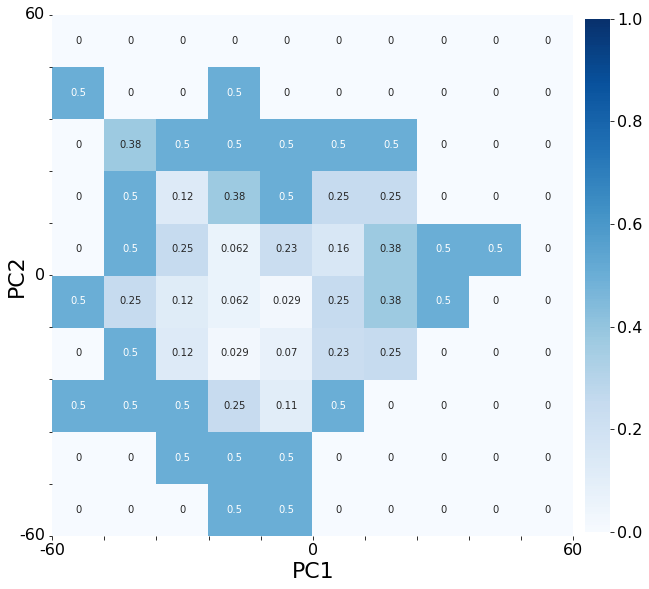

In [27]:
###################### CORRECTED bionomial probabilities FOR Z SCORED PCs ####################
#make numpy array with heatmap data
totalbps = []
minbphm = np.zeros((zsmallbins,zsmallbins))
for x in range(zsmallbins):
    for y in range(zsmallbins):
        current = TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1) & (TotalFrame['zsmall_PC2deltabins'] == y+1)][['zsmall_PC1deltabins','zsmall_PC2deltabins','zsmall_deltaPC1','zsmall_deltaPC2']].dropna()
        if current.empty or np.isnan(current.zsmall_deltaPC1.mean()):
            totalbps.append({'zPC1': x,
                          'zPC2': y,
                          'Binomial_Probability': 0})
            minbphm[y,x] = 0

        else:
            minbp = []
            for i, c in current.groupby(['zsmall_deltaPC1','zsmall_deltaPC2']):
                #number of transitions
                #forward transitions
                f = len(c)
                #reverse transitions
                r = len(TotalFrame[(TotalFrame['zsmall_PC1deltabins'] == x+1+c.zsmall_deltaPC1[0])
                   & (TotalFrame['zsmall_PC2deltabins'] == y+1+c.zsmall_deltaPC2[0])
                  & (TotalFrame['zsmall_deltaPC1'] == c.zsmall_deltaPC1[0]*-1)
                  & (TotalFrame['zsmall_deltaPC2'] == c.zsmall_deltaPC2[0]*-1)][['zsmall_PC1deltabins','zsmall_PC2deltabins','zsmall_deltaPC1','zsmall_deltaPC2']].dropna())
                #number of "trials"
                n = f + r
                #number of ways that transition COULD occur
                nf = math.factorial(n)/(math.factorial(f)*math.factorial((n-f)))
                #binomial probability
                bp = nf*(0.5**f)*(0.5**(n-f))
                totalbps.append({'zPC1': x,
                              'zPC2': y,
                              'Binomial_Probability':bp})
                minbp.append(bp)

            minbphm[y,x] = np.array(minbp).min()
                
totalbps = pd.DataFrame(totalbps)



#comparison of CELL features
fig, ax = plt.subplots(figsize=(zsmallbins,zsmallbins))
ax = sns.heatmap(
    minbphm,
    annot = True,
    vmin=0, vmax=1, #center=0,
    cmap=sns.color_palette("Blues", n_colors=200),
    square=True,
    cbar_kws={'fraction':0.046, 'pad':0.02}
)


ax.set_yticks(np.array(range(0,zsmallbins+1)))
ax.set_xticks(np.array(range(0,zsmallbins+1)))
ax.set_xticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    fontsize = 16
)
ax.set_yticklabels(
    np.linspace(-znbins, znbins, zsmallbins+1,dtype = int),
    rotation=0,
    fontsize = 16
)
lab = [0, round(zsmallbins/2), zsmallbins]
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i not in lab:
        l.set_visible(False)

        
#set axis titles
ax.set_xlabel('PC1', fontsize = 22)
ax.set_ylabel('PC2', fontsize = 22, labelpad = -8)           

cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
ax.invert_yaxis()


# plt.savefig(savedir + 'zPC1_PC2 binomial probabilities.png', bbox_inches='tight')